In [63]:
import re
from typing import Callable

import numpy as np
import torch
import torch.nn as nn

In [64]:
def unary_lambda(symbol: str) -> Callable[[str], str]:
    return lambda a: f"({a}){symbol}"


letters = "abcdefghijklmnopqrstuvwxyz"
digits = "0123456789"

quantifiers: set[str] = {"*", "+", "?"}

unary_regex: dict[str, Callable[[str], str]] = {
    **{symbol: unary_lambda(symbol) for symbol in quantifiers},
    **{symbol: unary_lambda(f"{symbol}?") for symbol in quantifiers},  # greedy versions
}
binary_regex: dict[str, Callable[[str, str], str]] = {
    "concat": lambda a, b: a + b,  # concatenation
    "|": lambda a, b: f"{a}|{b}",
}
many_to_one_regex: dict[str, Callable[[list[str]], str]] = {
    "[]": lambda a: "[" + "".join([f"({x})" for x in a]) + "]",  # set
    "^[]": lambda a: "[^" + "".join([f"({x})" for x in a]) + "]",  # not in set
    "concat_all": "".join,
}

specials_regex: set[str] = {
    ".",
    "^",
    "$",
}

operands_regex: set[str] = {
    *specials_regex,
    *[f"\\{s}" for s in specials_regex],
    *letters,
    *letters.upper(),
    *digits,
    *[f"\\{s}" for s in quantifiers],
}


def rpn_to_infix_regex(expression: list):
    global unary_regex, binary_regex, operands_regex, many_to_one_regex
    if len(expression) == 0:
        return ""

    if expression[-1] != "concat_all":
        expression.append("concat_all")
    stack = []

    for token in expression:
        if token in many_to_one_regex:
            stack = [many_to_one_regex[token](list(reversed(stack)))]
            continue

        if token in binary_regex:
            operand2 = stack.pop()
            operand1 = stack.pop()
            stack.append(binary_regex[token](operand1, operand2))
            continue
        if token in unary_regex:
            operand = stack.pop()
            stack.append(f"({token}{operand})")
            continue
        if token in operands_regex:
            stack.append(token)
            continue
        raise RuntimeError(f"Operand '{token}' is unknown")

    return stack[0]

In [65]:
numbers: set[str] = {
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "0",
}

In [66]:
IDX_TO_ACTIONS = {
    (i): action
    for i, action in enumerate(
        set().union(
            numbers,
            # operands_regex,
            # set(binary_regex.keys()),
            # set(unary_regex.keys()),
            # set(many_to_one_regex.keys()),
        )
    )
}
IDX_TO_ACTIONS[len(IDX_TO_ACTIONS)] = "FINISH"
ACTIONS_TO_IDX = {v: k for k, v in IDX_TO_ACTIONS.items()}

ACTIONS = set(ACTIONS_TO_IDX.keys())

In [67]:
IDX_TO_ACTIONS

{0: '1',
 1: '4',
 2: '6',
 3: '3',
 4: '2',
 5: '9',
 6: '8',
 7: '5',
 8: '0',
 9: '7',
 10: 'FINISH'}

In [68]:
HIGHEST = 100

In [ ]:
class Environment:
    penalty = -100
    # penalty = 1
    word_penalty = -10000
    len_penalty = -1

    max_steps = 5

    def __init__(
        self, text: str, target: list[int], words_count: int, penalty_weights: dict = None
    ):
        self.text = text
        self.target = target
        self.words_count = words_count
        self.current_index = 0
        self.regexp = None

        self.empty_state_idx = len(ACTIONS_TO_IDX)
        self.finish_action_idx = ACTIONS_TO_IDX["FINISH"]

        default_weights = {
            "f1": 10.0,
            "precision": 2.0,
            "recall": 2.0,
            "complexity": -0.5,
            "full_match": 50.0,
            "syntax_error": -100.0,
            "partial_progress": 5.0,
            "length_penalty": -0.3,
        }
        self.penalty_weights = penalty_weights or default_weights

        self.reset()

    def reset(self):
        self.step_idx = 0
        self.state = np.array([self.empty_state_idx] * self.max_steps)
        self.regex_history = []
        return self.get_state()

    def get_state(self):
        return self.state

    def get_state_tensor(self):
        return torch.FloatTensor(1 - (self.state / self.empty_state_idx)).unsqueeze(0)

    def step(self, action: int) -> tuple[list, float, bool]:
        self.step_idx += 1
        if action == self.finish_action_idx:
            reward = self.reward(self.state[: self.step_idx])
            # self.reset()
            return self.state, reward, True
        if self.step_idx > self.max_steps:  # finish action
            reward = self.reward(self.state[: self.step_idx])
            # self.reset()
            return self.state, reward, True

        self.state[self.step_idx - 1] = action
        return self.state, self.reward(self.state[: self.step_idx]), False

    def _calculate_metrics(self, regex_str: str):
        try:
            # compiled_re = re.compile(regex_str)
            # matches = [m.span() for m in compiled_re.finditer(self.text)]
            matches = [m.span() for m in re.finditer(regex_str, self.text)]

        except:
            print("ERROR_calculate_metrics")
            return None, None, None, True

        target_mask = self.target
        pred_mask = np.zeros_like(target_mask)

        # Create prediction mask
        for start, end in matches:
            pred_mask[start:end] = 1

        reverse_target_mask = [1 - x for x in target_mask]
        reverse_pred_mask = [1 - x for x in pred_mask]

        # Calculate metrics
        tp = np.logical_and(pred_mask, target_mask).sum()
        fp = np.logical_and(pred_mask, reverse_target_mask).sum()
        fn = np.logical_and(reverse_pred_mask, target_mask).sum()

        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-9)

        return f1, precision, recall, False

    def reward(self, regex_actions: list[int]):
        # Convert actions to regex string
        try:
            regex_symbols = [
                IDX_TO_ACTIONS[x]
                for x in regex_actions
                if x != self.finish_action_idx or x != self.empty_state_idx
            ]
            regex_str = rpn_to_infix_regex(regex_symbols)
            print(regex_str)
            self.regex_history.append(regex_str)
        except Exception:
            # Invalid regex construction
            print("ERROR_syntax_error")
            return self.penalty_weights["syntax_error"]

        # Calculate base metrics
        f1, precision, recall, is_invalid = self._calculate_metrics(regex_str)
        if is_invalid:
            return self.penalty_weights["syntax_error"]

        # Calculate components
        reward_components = {
            "f1": f1 * self.penalty_weights["f1"],
            "precision": precision * self.penalty_weights["precision"],
            "recall": recall * self.penalty_weights["recall"],
            # 'complexity': len(regex_str) * self.penalty_weights['complexity'],
            "length_penalty": len(regex_actions) * self.penalty_weights["length_penalty"],
        }

        # Full match bonus
        # if f1 >= 0.99:
        #     reward_components["full_match"] = self.penalty_weights["full_match"]

        # # Partial progress bonus (compare with previous attempts)
        # if len(self.regex_history) > 1:
        #     prev_f1 = self._calculate_metrics(self.regex_history[-2])[0] or 0
        #     reward_components["partial_progress"] = self.penalty_weights[
        #         "partial_progress"
        #     ] * (f1 - prev_f1)

        # Total reward calculation
        total_reward = sum(reward_components.values())

        # Apply non-linear scaling
        return np.sign(total_reward) * np.log1p(np.abs(total_reward))

In [70]:
device = torch.device("cpu")  # "cuda" if torch.cuda.is_available() else
len(ACTIONS)
device

device(type='cpu')

In [71]:
ACTIONS

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'FINISH'}

In [72]:
len(ACTIONS)

11

In [73]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [74]:
class PolicyNetwork(nn.Module):
    def __init__(self, observation_space: int, action_space: int, hidden_dim: int = 128):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.layer2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, action_space)

    def forward(self, x):
        x = F.leaky_relu(self.input_layer(x))
        x = F.leaky_relu(self.layer1(x))
        x = F.leaky_relu(self.layer2(x))
        actions = self.output_layer(x)
        return F.softmax(actions)

In [75]:
class A2CNet(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 128) -> None:
        super(A2CNet, self).__init__()

        self.body = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )

        self.policy = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, output_dim),
        )

        self.value = nn.Sequential(
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        body_out = self.body(x)
        return self.policy(body_out), self.value(body_out)

In [76]:
from random import random


def select_action(policy_network: nn.Module, env: Environment, on_policy=bool):
    state = env.get_state_tensor().to(device)
    action_probs = policy_network(state).squeeze()
    log_probs = torch.log(action_probs)
    cpu_action_probs = action_probs.detach().cpu().numpy()
    if on_policy:
        action = np.argmax(cpu_action_probs)
    else:
        action = np.random.choice(np.arange(len(ACTIONS)), p=cpu_action_probs)

    return action, log_probs, action_probs


class Agent:
    def choose_action(self, action_logits):
        return random.choices(range(len(action_logits)), F.softmax(action_logits, dim=0))[
            0
        ]

    def choose_optimal_action(self, action_logits) -> int:
        return int(np.argmax(F.softmax(action_logits, dim=0).cpu()).item())

In [77]:
policy_network = PolicyNetwork(Environment.max_steps, len(ACTIONS)).to(device)

gamma = 0.99
lr_policy_net = 2**-13
optimizer = torch.optim.Adam(policy_network.parameters(), lr=lr_policy_net)

In [78]:
train_data = """a45b """
array = [x.span() for x in re.finditer("[1-9]", train_data)]

target = [0 for _ in range(len(train_data))]
for it in array:
    for i in range(it[0], it[1]):
        target[i] = 1

In [79]:
target

[0, 1, 1, 0, 0]

In [80]:
# sum(np.bitwise_xor([0, 0, 1, 0], target))

In [81]:
env = Environment(train_data, target, 1)

In [82]:
best_score = -HIGHEST
best_env = env.reset()
NUM_EPISODES = 5000
scores = []

In [ ]:
from copy import copy

EVAL_INTERVAL = 500
cache_hits = 0

loop = tqdm(range(NUM_EPISODES))
for episode in loop:
    state = env.reset()
    done = False
    scores.append([-HIGHEST])
    prev_reward = 0
    cumulative_discount = 1.0
    prev_states = [env.get_state()]

    on_policy = (episode + 1) % EVAL_INTERVAL == 0

    loss = 0

    episode_reward = 0
    episode_log_probs = []
    rewards = []

    # run episode
    while not done:
        action, actions_log_probabilities, _ = select_action(
            policy_network, env, on_policy
        )
        # print("Action", action, IDX_TO_ACTIONS[action])
        episode_log_probs.append(actions_log_probabilities[action])

        next_state, new_score, done = env.step(action)

        if new_score > best_score:
            best_score = new_score
            best_env = copy(next_state)
            print(
                "Best Action",
                action,
                IDX_TO_ACTIONS[action],
                best_env,
                best_score,
                env.regexp,
            )

        prev_score = scores[episode][-1]

        # reward = round((new_score - prev_score), 2)
        reward = new_score
        rewards.append(reward)
        episode_reward += reward

        scores[episode].append(new_score)

        if done:
            env.reset()

    if not on_policy:
        discounted_returns = []
        running_return = 0

        # Reverse rewards and calculate cumulative discounted returns
        for r in reversed(rewards):
            running_return = r + 0.99 * running_return
            discounted_returns.insert(0, running_return)

        returns_tensor = torch.tensor(discounted_returns)
        # returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-9)

        policy_loss = []
        for log_prob, Gt in zip(episode_log_probs, returns_tensor):
            policy_loss.append(-log_prob * Gt)
        total_loss = torch.stack(policy_loss).sum()

        # num_steps = len(episode_log_probs)
        # per_timestep_losses = [
        #     -log_prob * episode_reward for log_prob in episode_log_probs
        # ]
        # total_loss = torch.stack(per_timestep_losses).sum()

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    loop.set_postfix({"best": best_score})

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\Kiaver\AppData\Local\Temp\ipykernel_12292\4078418271.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(actions)
  0%|          | 14/5000 [00:00<00:36, 135.92it/s, best=2.34]

4
Best Action 1 4 [ 1 11 11 11 11] 2.338595529418472 None
64
364
3364
23364
23364
8
08
208
ERROR_syntax_error
0
80
980
5980
55980
55980
0
40
740
6740
ERROR_syntax_error
9
ERROR_syntax_error
5
15
ERROR_syntax_error
8
88
788
2788
72788
72788
9
49
649
8649
28649
28649
3
33
233
1233
21233
21233
8
08
208
8208
78208
78208
0
10
910
6910
16910
16910
8
28
028
9028
49028
49028
9
49
ERROR_syntax_error
6
76
876
8876
08876
08876
3
73
573
ERROR_syntax_error
4
24
424
7424
37424
37424
3
53
753
2753
22753
22753
2
52
652
9652
59652
59652
ERROR_syntax_error
8
38
138
6138
86138
86138
3
33
933
1933
ERROR_syntax_error
ERROR_syntax_error
8
88
088
5088
ERROR_syntax_error
6
86
686
6686
76686
76686
9
19
019
6019
86019
86019
3
73
ERROR_syntax_error
3
93
ERROR_syntax_error
7
87
987
4987
84987
84987
3
73
173
0173
90173
90173
8
38
038
4038
94038
94038


  1%|          | 53/5000 [00:00<00:28, 176.59it/s, best=2.34]

7
17
517
6517
96517
96517
ERROR_syntax_error
7
87
787
8787
08787
08787
6
ERROR_syntax_error
8
08
008
0008
30008
30008
4
84
784
7784
47784
47784
9
19
219
ERROR_syntax_error
2
32
332
8332
48332
48332
9
89
289
9289
49289
49289
7
47
647
1647
11647
11647
2
ERROR_syntax_error
2
92
592
3592
23592
23592
4
14
814
0814
00814
00814
5
95
ERROR_syntax_error
7
17
817
2817
92817
92817
4
74
374
3374
93374
93374
8
28
928
6928
86928
86928
8
48
848
0848
30848
30848
3
83
783
8783
28783
28783
1
11
911
9911
69911
69911
3
63
ERROR_syntax_error
6
ERROR_syntax_error
6
76
676
8676
ERROR_syntax_error
0
10
010
4010
84010
84010
3
43
343
6343
96343
96343
4
44
344
2344
92344
92344
5
95
ERROR_syntax_error
5
55
955
ERROR_syntax_error
ERROR_syntax_error
9
79
879
1879
71879
71879
7
ERROR_syntax_error
1
ERROR_syntax_error
2
22
222
4222
64222
64222
9
19
ERROR_syntax_error
8
48
748
0748
50748
50748
4
44
444
ERROR_syntax_error
9
49
149
0149
70149
70149


  2%|▏         | 96/5000 [00:00<00:24, 199.90it/s, best=2.34]

8
88
188
6188
76188
76188
0
20
020
7020
67020
67020
ERROR_syntax_error
4
44
144
5144
65144
65144
1
91
491
8491
98491
98491
8
58
458
6458
86458
86458
3
43
243
3243
83243
83243
6
66
ERROR_syntax_error
8
88
388
9388
89388
89388
8
68
068
0068
50068
50068
6
86
386
0386
70386
70386
0
10
010
4010
94010
94010
5
05
105
3105
03105
03105
4
24
924
0924
30924
30924
ERROR_syntax_error
7
ERROR_syntax_error
2
22
ERROR_syntax_error
8
88
188
0188
50188
50188
0
00
400
5400
45400
45400
7
17
617
6617
ERROR_syntax_error
5
85
085
6085
ERROR_syntax_error
1
ERROR_syntax_error
1
71
371
5371
45371
45371
ERROR_syntax_error
2
62
662
0662
00662
00662
0
30
130
1130
81130
81130
7
47
347
1347
61347
61347
0
80
280
7280
07280
07280
7
07
ERROR_syntax_error
2
62
162
2162
52162
52162
5
85
685
6685
ERROR_syntax_error
6
96
796
3796
03796
03796
0
70
ERROR_syntax_error
4
84
984
9984
39984
39984
0
00
600
2600
02600
02600
ERROR_syntax_error
6
96
796
6796
36796
36796
3
ERROR_syntax_error
2
22
122
8122
58122
58122


  3%|▎         | 139/5000 [00:00<00:24, 201.32it/s, best=2.34]

0
90
090
2090
72090
72090
8
18
718
9718
89718
89718
1
91
191
0191
20191
20191
4
54
454
9454
69454
69454
1
31
431
3431
13431
13431
6
56
756
9756
49756
49756
8
58
958
3958
63958
63958
7
27
927
8927
08927
08927
2
82
ERROR_syntax_error
8
88
188
ERROR_syntax_error
1
41
741
7741
97741
97741
ERROR_syntax_error
2
82
482
ERROR_syntax_error
5
ERROR_syntax_error
ERROR_syntax_error
1
81
781
3781
03781
03781
0
90
290
4290
94290
94290
9
39
739
4739
ERROR_syntax_error
2
52
252
8252
78252
78252
8
78
078
4078
34078
34078
2
62
162
1162
91162
91162
0
70
670
2670
72670
72670
1
51
ERROR_syntax_error
8
98
998
6998
76998
76998
5
75
875
6875
06875
06875
ERROR_syntax_error
2
52
252
0252
80252
80252
9
99
399
ERROR_syntax_error
0
10
310
2310
12310
12310
4
24
624
3624
03624
03624
3
63
463
4463
74463
74463
0
90
190
3190
43190
43190
2
62
ERROR_syntax_error
6
86
286
4286
84286
84286
6
76
276
2276
02276
02276
2
22
822
4822
44822
44822


  3%|▎         | 160/5000 [00:00<00:25, 189.36it/s, best=2.34]

9
39
839
7839
77839
77839
2
22
822
2822
62822
62822
ERROR_syntax_error
2
02
602
4602
84602
84602
2
32
032
6032
56032
56032
ERROR_syntax_error
9
79
379
0379
80379
80379
8
58
ERROR_syntax_error
4
ERROR_syntax_error
5
65
565
1565
71565
71565
1
51
051
0051
20051
20051
8
78
978
5978
35978
35978
4
14
614
5614
65614
65614
1
ERROR_syntax_error
8
38
738
8738
88738
88738
0
20
120
0120
70120
70120
0
00
700
4700
84700
84700
1
41
641
0641
30641
30641
3
53
253
0253
60253
60253
4
54
554
8554
88554
88554
8
98
498
5498
85498
85498
9
89
089
1089
41089
41089
ERROR_syntax_error
2
ERROR_syntax_error
4
24
524
2524
02524
02524
0
20
ERROR_syntax_error
6
56
256
5256
95256
95256
0
90
090
4090
14090
14090
9
99
099
4099
24099
24099
8
78
978
9978
59978
59978
0
20
220
9220
49220
49220
4
94
594
4594
04594
04594
0
60
060
3060
33060
33060
6
96
096
2096
72096
72096


  4%|▍         | 201/5000 [00:01<00:25, 189.70it/s, best=2.34]

7
77
577
4577
54577
54577
4
24
524
9524
29524
29524
5
05
105
4105
34105
34105
7
97
697
8697
78697
78697
7
37
537
0537
60537
60537
2
82
482
4482
44482
44482
2
02
002
6002
46002
46002
0
40
540
8540
38540
38540
5
25
025
9025
89025
89025
ERROR_syntax_error
9
29
729
6729
06729
06729
8
28
128
6128
16128
16128
0
ERROR_syntax_error
6
96
496
4496
54496
54496
2
42
842
5842
25842
25842
9
09
ERROR_syntax_error
1
41
941
9941
79941
79941
0
50
350
4350
74350
74350
ERROR_syntax_error
ERROR_syntax_error
2
02
902
1902
51902
51902
6
36
536
6536
66536
66536
8
98
298
8298
68298
68298
5
95
095
2095
02095
02095
0
80
580
4580
84580
84580
6
96
796
0796
60796
60796
0
40
540
8540
38540
38540
0
80
280
1280
31280
31280
5
75
975
5975
75975
75975
2
12
312
5312
65312
65312
9
29
929
5929
75929
75929
4
64
564
5564
35564
35564
6
86
886
4886
54886
54886
1
21
121
0121
20121
20121
ERROR_syntax_error
5
75
975
5975
35975
35975


  5%|▍         | 242/5000 [00:01<00:25, 186.68it/s, best=2.34]

9
59
ERROR_syntax_error
9
69
069
8069
18069
18069
3
43
843
2843
72843
72843
8
28
428
0428
50428
50428
7
37
637
0637
40637
40637
ERROR_syntax_error
1
21
821
6821
66821
66821
1
61
961
1961
71961
71961
9
49
949
1949
41949
41949
1
01
801
9801
19801
19801
5
15
115
4115
74115
74115
9
49
849
9849
69849
69849
2
92
292
ERROR_syntax_error
4
34
234
9234
59234
59234
1
61
461
7461
67461
67461
7
97
197
1197
21197
21197
9
89
589
1589
81589
81589
7
17
217
9217
09217
09217
3
93
293
4293
44293
44293
0
80
880
ERROR_syntax_error
5
05
505
1505
01505
01505
0
50
ERROR_syntax_error
6
56
456
6456
96456
96456
4
34
034
8034
78034
78034
9
19
019
0019
40019
40019
5
55
355
5355
05355
05355
7
37
737
8737
68737
68737
6
56
356
7356
07356
07356
0
50
050
2050
12050
12050
0
20
820
0820
50820
50820
6
16
216
1216
71216
71216
5
75
675
6675
66675
66675
1
21
921
6921
66921
66921
9
99
099
0099
30099
30099


  6%|▌         | 287/5000 [00:01<00:23, 203.36it/s, best=2.34]

1
61
061
6061
26061
26061
0
90
090
4090
34090
34090
8
68
ERROR_syntax_error
8
68
168
7168
97168
97168
6
76
476
8476
08476
08476
0
ERROR_syntax_error
6
ERROR_syntax_error
8
88
488
6488
36488
36488
ERROR_syntax_error
5
05
505
0505
90505
90505
3
73
773
6773
96773
96773
5
15
015
8015
58015
58015
0
60
160
3160
63160
63160
6
46
346
5346
35346
35346
2
52
352
1352
91352
91352
5
55
855
3855
03855
03855
5
ERROR_syntax_error
9
29
229
6229
26229
26229
7
37
337
2337
12337
12337
3
43
943
2943
52943
52943
6
96
196
8196
48196
48196
9
59
259
1259
51259
51259
7
07
707
6707
46707
46707
9
89
089
0089
40089
40089
2
52
252
9252
49252
49252
7
57
057
6057
16057
16057
9
79
ERROR_syntax_error
6
46
846
9846
59846
59846
3
63
063
2063
82063
82063
0
10
710
0710
50710
50710
7
57
557
2557
02557
02557
8
48
148
0148
60148
60148
8
18
718
4718
84718
84718
6
56
456
5456
35456
35456
7
47
347
8347
48347
48347
4
84
684
0684
10684
10684
1
31
531
5531
05531
05531
7
57
757
3757
33757
33757
9
59
559
7559
87559
87559
0
00
000
300

  6%|▌         | 308/5000 [00:01<00:24, 191.94it/s, best=2.34]

8
48
948
4948
44948
44948
8
78
378
6378
96378
96378
9
09
509
0509
80509
80509
0
00
000
9000
09000
09000
0
00
600
4600
44600
44600
6
86
286
9286
59286
59286
8
08
708
0708
50708
50708
0
40
240
7240
87240
87240
5
65
065
5065
85065
85065
7
07
107
0107
50107
50107
2
62
862
2862
92862
92862
8
68
468
7468
97468
97468
4
54
854
5854
25854
25854
0
50
750
9750
09750
09750
ERROR_syntax_error
7
97
497
9497
79497
79497
4
54
754
4754
94754
94754
1
71
971
9971
89971
89971
2
12
ERROR_syntax_error
7
97
097
1097
01097
01097
0
70
670
9670
29670
29670
0
50
450
4450
94450
94450
0
10
510
0510
10510
10510
1
01
001
0001
60001
60001
1
41
241
5241
45241
45241
0
50
550
7550
37550
37550
0
00
800
5800
75800
75800
3
43
943
4943
34943
34943
5
55
755
7755
97755
97755
7
67
067
5067
55067
55067
3
73
373
0373
80373
80373
2
32
032
0032
30032
30032
8
38
438
6438
66438
66438


  7%|▋         | 348/5000 [00:01<00:24, 188.85it/s, best=2.34]

2
52
552
9552
29552
29552
4
14
514
6514
56514
56514
9
59
059
2059
02059
02059
7
07
707
3707
83707
83707
0
00
100
4100
84100
84100
0
50
350
9350
59350
59350
0
50
650
9650
99650
99650
2
92
892
8892
58892
58892
4
64
664
0664
90664
90664
1
91
091
5091
75091
75091
4
44
544
5544
95544
95544
6
26
026
0026
70026
70026
0
50
050
5050
75050
75050
5
05
605
7605
37605
37605
2
02
302
0302
00302
00302
4
24
924
8924
68924
68924
7
77
177
1177
71177
71177
1
91
991
1991
51991
51991
7
67
767
0767
70767
70767
6
76
876
7876
27876
27876
6
26
226
0226
50226
50226
4
84
884
0884
20884
20884
9
09
309
3309
23309
23309
5
65
665
8665
38665
38665
6
56
356
6356
06356
06356
6
26
226
2226
42226
42226
7
17
017
7017
97017
97017
3
83
083
5083
35083
35083
0
70
470
7470
07470
07470
8
18
218
5218
05218
05218
7
57
257
7257
87257
87257
1
01
801
0801
00801
00801
9
79
179
8179
88179
88179
8
08
808
0808
50808
50808
8
ERROR_syntax_error


  8%|▊         | 387/5000 [00:02<00:24, 187.86it/s, best=4.19]

0
50
550
8550
98550
98550
3
53
253
7253
07253
07253
2
02
002
5002
65002
65002
8
28
628
8628
68628
68628
6
56
756
1756
61756
61756
2
02
202
5202
05202
05202
6
76
076
8076
78076
78076
7
77
977
8977
08977
08977
5
75
675
6675
66675
66675
6
26
026
3026
03026
03026
0
50
050
2050
92050
92050
5
15
115
7115
57115
57115
9
79
779
0779
30779
30779
5
05
805
4805
74805
74805
6
06
506
4506
14506
14506
1
91
591
2591
72591
72591
9
79
179
1179
51179
51179
0
50
ERROR_syntax_error
1
61
261
0261
80261
80261
7
37
337
0337
40337
40337
0
00
900
1900
51900
51900
9
09
109
0109
80109
80109
2
52
052
8052
08052
08052
5
75
975
8975
78975
78975
5
35
235
0235
80235
80235
9
89
689
6689
56689
56689
8
68
868
6868
56868
56868
9
39
639
5639
05639
05639
6
96
096
5096
05096
05096
9
29
029
2029
52029
52029
0
10
610
0610
50610
50610
5
45
Best Action 1 4 [ 7  1 11 11 11] 4.190664333037734 None
245
4245
84245
84245
8
48
548
7548
87548
87548
5
45
945
0945
90945
90945


  8%|▊         | 406/5000 [00:02<00:25, 183.23it/s, best=4.19]

7
07
607
6607
96607
96607
0
60
560
0560
50560
50560
6
96
496
2496
42496
42496
6
96
696
2696
82696
82696
0
60
560
2560
62560
62560
4
24
024
4024
04024
04024
2
92
092
0092
80092
80092
0
60
060
8060
98060
98060
6
46
046
5046
05046
05046
3
63
563
9563
09563
09563
2
62
062
6062
56062
56062
5
85
585
5585
75585
75585
9
69
569
8569
08569
08569
4
94
894
7894
47894
47894
5
55
555
8555
98555
98555
0
00
800
0800
00800
00800
0
50
050
0050
00050
00050
7
47
347
6347
06347
06347
1
61
361
0361
80361
80361
0
50
650
2650
02650
02650
5
85
185
0185
30185
30185
9
69
269
8269
08269
08269
3
53
653
6653
76653
76653
3
33
533
5533
95533
95533
6
56
756
4756
24756
24756
6
26
526
6526
06526
06526
0
40
540
6540
56540
56540
6
56
356
4356
74356
74356
9
89
089
6089
66089
66089
5
45
545
0545
00545
00545
0
00
200
8200
48200
48200
0
40
040
8040
08040
08040
3
63
563
4563
34563
34563


  9%|▉         | 444/5000 [00:02<00:25, 178.36it/s, best=4.19]

8
68
168
2168
42168
42168
2
02
902
5902
15902
15902
5
75
575
8575
28575
28575
4
54
254
5254
35254
35254
6
96
396
5396
75396
75396
4
64
164
6164
06164
06164
9
09
009
5009
65009
65009
2
12
612
6612
16612
16612
0
30
830
7830
67830
67830
2
02
702
8702
08702
08702
2
52
952
8952
68952
68952
0
30
030
5030
05030
05030
7
97
797
1797
91797
91797
1
61
561
6561
66561
66561
1
61
361
5361
05361
05361
7
07
407
4407
14407
14407
9
59
159
1159
61159
61159
0
40
140
7140
47140
47140
0
50
550
7550
07550
07550
4
04
704
5704
95704
95704
6
66
166
6166
06166
06166
8
58
058
4058
24058
24058
0
30
330
3330
83330
83330
8
48
848
7848
07848
07848
6
36
436
0436
40436
40436
5
95
395
0395
50395
50395
5
55
255
7255
ERROR_syntax_error
3
63
263
6263
86263
86263
4
94
594
3594
83594
83594
0
00
200
7200
97200
97200
0
30
030
0030
80030
80030
6
36
736
3736
23736
23736
2
62
362
0362
70362
70362


 10%|▉         | 482/5000 [00:02<00:24, 181.55it/s, best=4.19]

5
35
035
5035
65035
65035
6
16
216
0216
00216
00216
0
00
200
1200
51200
51200
9
69
469
5469
45469
45469
2
82
582
5582
95582
95582
8
58
258
0258
80258
80258
6
86
586
8586
68586
68586
3
03
903
0903
30903
30903
4
74
874
2874
52874
52874
3
23
023
6023
76023
76023
6
36
736
9736
09736
09736
0
00
600
0600
50600
50600
8
58
158
0158
90158
90158
9
59
159
5159
05159
05159
4
04
504
9504
19504
19504
5
65
365
7365
37365
37365
4
84
084
0084
10084
10084
9
09
109
0109
00109
00109
7
87
987
1987
11987
11987
9
39
039
4039
34039
34039
8
98
098
2098
82098
82098
4
94
494
5494
95494
95494
2
12
812
0812
60812
60812
7
27
727
0727
10727
10727
9
19
519
9519
09519
09519
5
55
055
6055
26055
26055
7
37
537
4537
04537
04537
6
06
106
7106
07106
07106
1
31
431
9431
09431
09431
6
ERROR_syntax_error
4
84
384
5384
15384
15384
0
00
400
1400
01400
01400
5
75
075
4075
44075
44075
8
28
528
2528
42528
42528


 10%|█         | 519/5000 [00:02<00:25, 174.62it/s, best=4.19]

9
09
609
2609
72609
72609
1
61
061
0061
70061
70061
8
88
588
8588
68588
68588
0
70
270
1270
01270
01270
9
09
709
6709
06709
06709
6
06
906
9906
79906
79906
4
74
174
3174
83174
83174
8
38
538
7538
47538
47538
4
84
084
6084
16084
16084
0
00
000
0000
00000
00000
8
28
628
3628
03628
03628
8
78
278
7278
07278
07278
2
22
422
4422
74422
74422
2
72
072
6072
46072
46072
9
49
049
0049
00049
00049
0
40
240
0240
40240
40240
4
64
064
0064
00064
00064
6
36
836
6836
36836
36836
4
04
204
3204
43204
43204
2
32
632
0632
10632
10632
9
49
549
3549
83549
83549
5
55
155
3155
03155
03155
4
64
064
8064
78064
78064
6
96
496
0496
50496
50496
4
14
014
7014
67014
67014
5
65
065
4065
74065
74065
9
09
009
9009
59009
59009
9
89
089
0089
10089
10089
9
09
909
4909
24909
24909
9
09
909
0909
00909
00909
0
10
510
5510
25510
25510


 11%|█         | 537/5000 [00:02<00:25, 176.15it/s, best=4.19]

8
58
058
4058
74058
74058
7
07
807
2807
42807
42807
5
05
705
5705
95705
95705
8
38
038
3038
73038
73038
7
57
057
1057
01057
01057
6
66
966
9966
89966
89966
1
51
051
9051
89051
89051
9
79
079
0079
60079
60079
2
82
282
0282
00282
00282
5
45
945
4945
64945
64945
4
74
874
3874
03874
03874
1
31
731
5731
55731
55731
7
47
547
0547
00547
00547
0
50
950
6950
96950
96950
8
48
348
0348
70348
70348
6
76
476
6476
76476
76476
7
47
947
3947
63947
63947
5
55
955
1955
01955
01955
4
64
664
0664
00664
00664
8
48
848
8848
08848
08848
9
39
039
4039
34039
34039
8
08
508
7508
07508
07508
1
01
901
7901
07901
07901
9
99
699
6699
66699
66699
0
70
470
7470
67470
67470
0
30
030
8030
48030
48030
6
06
706
1706
01706
01706
0
10
010
1010
71010
71010
7
07
607
8607
08607
08607
5
95
995
8995
08995
08995
0
70
070
7070
07070
07070
9
19
519
5519
75519
75519
3
13
413
5413
65413
65413
4
34
734
0734
00734
00734
1
01
001
7001
77001
77001


 12%|█▏        | 575/5000 [00:03<00:24, 179.31it/s, best=4.19]

0
50
750
4750
54750
54750
1
01
501
6501
46501
46501
1
21
021
7021
77021
77021
7
07
307
0307
00307
00307
7
87
387
3387
43387
43387
7
97
997
0997
50997
50997
4
04
704
3704
43704
43704
5
75
075
5075
55075
55075
0
20
020
7020
17020
17020
9
09
509
3509
83509
83509
0
60
460
6460
56460
56460
8
08
808
4808
24808
24808
8
58
758
5758
35758
35758
0
50
150
0150
30150
30150
6
66
066
3066
03066
03066
6
76
576
7576
07576
07576
1
71
271
0271
80271
80271
6
36
536
3536
73536
73536
5
35
535
2535
22535
22535
0
70
470
9470
99470
99470
6
56
656
0656
30656
30656
6
36
036
6036
06036
06036
8
98
998
0998
10998
10998
5
05
105
2105
72105
72105
0
80
580
0580
00580
00580
2
12
912
0912
50912
50912
0
20
620
7620
37620
37620
4
14
514
5514
85514
85514
0
50
550
3550
63550
63550
7
07
007
5007
65007
65007
4
44
544
0544
30544
30544
9
19
819
2819
72819
72819
3
03
203
8203
28203
28203
6
66
566
0566
60566
60566


 12%|█▏        | 613/5000 [00:03<00:24, 180.72it/s, best=4.19]

0
10
810
6810
76810
76810
4
54
854
4854
34854
34854
2
12
512
0512
60512
60512
7
47
347
7347
07347
07347
1
51
151
1151
01151
01151
5
85
885
7885
97885
97885
5
35
835
1835
71835
71835
0
00
500
0500
40500
40500
0
40
040
6040
86040
86040
0
30
530
5530
15530
15530
9
09
709
0709
80709
80709
1
01
601
9601
09601
09601
3
73
073
9073
69073
69073
6
06
006
4006
04006
04006
3
33
133
3133
03133
03133
4
54
754
6754
66754
66754
2
02
402
0402
10402
10402
3
33
533
0533
20533
20533
0
50
450
8450
98450
98450
9
39
739
7739
77739
77739
1
11
711
0711
00711
00711
9
79
879
7879
97879
97879
0
60
860
0860
50860
50860
5
05
105
7105
17105
17105
5
45
945
9945
39945
39945
4
94
294
0294
90294
90294
5
85
485
7485
77485
77485
2
52
852
1852
31852
31852
9
69
069
0069
20069
20069
2
42
442
5442
05442
05442
3
03
103
7103
87103
87103
1
01
601
5601
05601
05601
6
56
656
9656
79656
79656
8
58
458
4458
54458
54458


 13%|█▎        | 652/5000 [00:03<00:23, 183.33it/s, best=4.19]

2
72
772
4772
34772
34772
3
73
773
1773
21773
21773
9
49
749
9749
79749
79749
9
89
889
5889
85889
85889
2
02
802
7802
77802
77802
9
79
579
0579
50579
50579
0
90
090
5090
35090
35090
2
92
692
1692
51692
51692
ERROR_syntax_error
2
42
242
3242
03242
03242
9
49
349
6349
06349
06349
5
25
025
6025
06025
06025
0
50
850
6850
96850
96850
5
05
005
9005
99005
99005
5
65
865
9865
99865
99865
4
44
844
4844
34844
34844
0
90
290
1290
51290
51290
3
63
063
0063
20063
20063
0
80
380
4380
44380
44380
4
34
334
3334
03334
03334
0
00
100
4100
94100
94100
5
05
105
0105
00105
00105
0
50
450
2450
02450
02450
6
06
106
6106
66106
66106
0
00
300
0300
50300
50300
5
55
255
6255
06255
06255
7
67
167
3167
53167
53167
4
04
604
4604
54604
54604
3
03
003
8003
18003
18003
4
44
544
5544
75544
75544
1
61
261
0261
80261
80261
6
26
726
5726
55726
55726
6
96
096
6096
76096
76096
0
10
110
2110
42110
42110


 13%|█▎        | 671/5000 [00:03<00:24, 179.54it/s, best=4.19]

4
54
454
9454
59454
59454
5
35
435
6435
66435
66435
3
73
073
0073
10073
10073
4
64
364
2364
52364
52364
7
67
667
1667
01667
01667
9
09
109
2109
82109
82109
ERROR_syntax_error
0
80
480
2480
02480
02480
6
96
496
8496
08496
08496
4
14
614
5614
05614
05614
0
80
380
0380
30380
30380
0
10
710
9710
79710
79710
0
00
100
5100
45100
45100
7
77
777
1777
01777
01777
3
53
553
0553
80553
80553
6
56
056
1056
51056
51056
6
76
676
3676
23676
23676
8
78
378
0378
00378
00378
6
56
956
8956
08956
08956
4
94
094
6094
06094
06094
0
50
150
0150
00150
00150
5
65
865
8865
78865
78865
4
04
304
1304
51304
51304
5
05
005
7005
17005
17005
7
47
047
0047
80047
80047
0
00
800
0800
00800
00800
0
70
070
7070
07070
07070
3
83
283
3283
03283
03283
7
67
667
0667
40667
40667
7
07
107
6107
06107
06107


 14%|█▍        | 707/5000 [00:03<00:25, 171.45it/s, best=4.19]

4
54
254
7254
17254
17254
7
57
557
0557
10557
10557
9
19
819
4819
24819
24819
6
06
906
5906
05906
05906
5
15
215
2215
82215
82215
3
53
453
7453
07453
07453
4
64
464
5464
45464
45464
0
30
030
3030
63030
63030
2
22
222
3222
ERROR_syntax_error
2
42
442
5442
05442
05442
3
03
903
1903
01903
01903
5
85
485
1485
11485
11485
0
70
170
9170
09170
09170
9
19
019
8019
58019
58019
8
28
028
0028
60028
60028
6
06
506
0506
00506
00506
8
68
068
5068
65068
65068
6
86
186
8186
78186
78186
4
04
004
0004
30004
30004
6
06
406
9406
09406
09406
4
44
644
3644
63644
63644
3
83
683
7683
07683
07683
2
02
502
5502
05502
05502
5
95
095
0095
70095
70095
5
45
945
3945
03945
03945
0
10
410
9410
59410
59410
8
48
448
1448
01448
01448
8
18
418
0418
00418
00418
0
50
150
1150
11150
11150
8
88
888
9888
59888
59888
8
48
348
8348
48348
48348
0
30
030
8030
78030
78030
5
05
705
4705
44705
44705


 15%|█▍        | 744/5000 [00:04<00:24, 176.99it/s, best=4.19]

8
78
778
0778
90778
90778
8
88
888
3888
43888
43888
0
00
500
7500
57500
57500
7
77
077
8077
18077
18077
9
59
359
6359
66359
66359
9
29
429
7429
07429
07429
3
13
613
3613
03613
03613
5
05
005
0005
40005
40005
6
06
006
0006
40006
40006
7
07
207
5207
65207
65207
8
18
018
6018
46018
46018
0
00
400
8400
68400
68400
5
75
575
8575
08575
08575
4
94
794
0794
00794
00794
0
00
000
4000
04000
04000
0
70
070
8070
48070
48070
9
89
089
0089
10089
10089
9
19
319
4319
04319
04319
1
01
001
1001
01001
01001
1
31
231
8231
08231
08231
4
34
534
9534
09534
09534
6
16
016
4016
44016
44016
2
42
042
7042
07042
07042
7
57
857
0857
70857
70857
1
41
941
0941
60941
60941
9
99
799
8799
48799
48799
5
65
965
0965
70965
70965
0
50
050
0050
10050
10050
0
00
400
0400
80400
80400
1
01
501
4501
74501
74501
0
60
460
7460
07460
07460
1
81
781
6781
46781
46781
0
90
690
9690
59690
59690
7
77
977
3977
43977
43977


 16%|█▌        | 781/5000 [00:04<00:23, 179.29it/s, best=4.19]

4
14
014
1014
01014
01014
2
02
002
0002
30002
30002
3
33
533
4533
04533
04533
7
57
257
6257
06257
06257
7
47
047
0047
60047
60047
0
60
060
6060
06060
06060
8
58
658
5658
65658
65658
0
10
010
1010
81010
81010
8
08
708
4708
04708
04708
0
00
100
6100
06100
06100
4
64
564
5564
85564
85564
0
90
190
7190
07190
07190
6
96
896
0896
40896
40896
5
95
695
0695
70695
70695
8
98
098
7098
07098
07098
5
75
075
7075
77075
77075
0
40
540
0540
80540
80540
0
00
700
7700
07700
07700
7
87
087
0087
00087
00087
4
64
064
5064
15064
15064
0
50
750
4750
74750
74750
9
89
389
6389
96389
96389
2
52
452
4452
94452
94452
ERROR_syntax_error
6
66
166
4166
04166
04166
8
88
788
6788
86788
86788
4
44
144
4144
74144
74144
8
48
048
0048
30048
30048
6
66
766
9766
59766
59766
1
91
791
0791
00791
00791
6
56
556
8556
68556
68556
1
81
081
0081
00081
00081
1
51
751
1751
01751
01751
9
49
649
7649
77649
77649


 16%|█▋        | 818/5000 [00:04<00:23, 181.15it/s, best=4.19]

1
61
361
0361
50361
50361
5
05
305
8305
98305
98305
0
90
190
9190
89190
89190
6
36
036
4036
64036
64036
5
15
515
0515
00515
00515
0
00
900
1900
01900
01900
4
04
004
6004
76004
76004
5
55
455
0455
00455
00455
3
53
653
4653
04653
04653
0
50
450
7450
17450
17450
3
33
933
6933
76933
76933
1
01
701
4701
44701
44701
9
69
669
0669
10669
10669
0
90
590
1590
61590
61590
2
02
802
5802
05802
05802
0
00
000
6000
36000
36000
8
08
508
3508
03508
03508
3
03
503
3503
33503
33503
8
68
468
5468
05468
05468
1
51
551
7551
57551
57551
5
05
805
9805
09805
09805
8
68
068
4068
64068
64068
3
63
063
9063
59063
59063
5
15
015
0015
40015
40015
0
70
170
2170
62170
62170
4
04
904
0904
50904
50904
8
58
758
7758
77758
77758
2
62
462
5462
95462
95462
5
05
805
8805
08805
08805
0
70
470
5470
45470
45470
0
20
020
0020
30020
30020
9
09
009
4009
04009
04009
6
06
406
0406
50406
50406
8
08
608
1608
01608
01608
7
07
007
6007
86007
86007


 17%|█▋        | 858/5000 [00:04<00:22, 187.97it/s, best=4.19]

0
60
060
1060
01060
01060
8
88
288
9288
09288
09288
6
06
006
5006
95006
95006
5
15
115
5115
95115
95115
0
30
330
3330
73330
73330
6
46
046
5046
55046
55046
8
98
698
0698
70698
70698
2
02
502
7502
07502
07502
0
50
250
5250
35250
35250
4
04
504
5504
45504
45504
8
18
218
6218
56218
56218
4
84
584
4584
04584
04584
0
60
060
4060
04060
04060
9
09
109
0109
00109
00109
0
20
020
9020
29020
29020
0
10
310
8310
78310
78310
7
77
577
3577
13577
13577
9
09
009
0009
00009
00009
6
56
156
4156
54156
54156
6
56
856
4856
54856
54856
5
45
545
0545
50545
50545
0
30
130
8130
08130
08130
3
03
003
1003
51003
51003
1
51
751
1751
01751
01751
4
64
064
0064
50064
50064
3
33
733
4733
14733
14733
4
94
194
7194
77194
77194
3
03
603
4603
74603
74603
2
12
012
7012
07012
07012
0
70
370
9370
59370
59370
0
70
570
8570
08570
08570
0
00
300
3300
03300
03300
0
50
550
0550
00550
00550
4
44
044
0044
50044
50044
5
45
645
7645
37645
37645
4
64
364
3364
03364
03364


 18%|█▊        | 877/5000 [00:04<00:21, 188.46it/s, best=4.19]

9
09
009
8009
78009
78009
1
11
011
7011
57011
57011
7
67
767
4767
54767
54767
8
88
488
9488
69488
69488
4
34
434
9434
39434
39434
6
86
886
4886
24886
24886
7
07
007
6007
06007
06007
9
09
009
2009
32009
32009
0
50
950
0950
50950
50950
6
06
406
0406
50406
50406
5
35
035
5035
05035
05035
9
09
709
6709
06709
06709
0
70
770
0770
40770
40770
9
79
779
6779
06779
06779
9
89
689
6689
76689
76689
6
06
506
0506
60506
60506
5
45
045
0045
60045
60045
5
85
085
0085
00085
00085
7
07
707
0707
00707
00707
2
62
562
5562
05562
05562
9
09
009
0009
90009
90009
0
20
820
0820
70820
70820
0
90
090
9090
69090
69090
0
40
640
3640
03640
03640
6
26
526
4526
44526
44526
5
05
405
4405
04405
04405
0
00
000
5000
05000
05000
2
42
542
0542
00542
00542
1
01
501
0501
60501
60501
9
39
939
0939
00939
00939
0
40
040
0040
60040
60040
5
55
055
0055
00055
00055
6
46
646
0646
40646
40646
2
32
032
4032
04032
04032
6
06
706
4706
04706
04706


 18%|█▊        | 916/5000 [00:05<00:21, 188.95it/s, best=4.19]

5
75
775
8775
68775
68775
0
50
650
2650
02650
02650
5
05
005
1005
01005
01005
0
00
000
4000
94000
94000
5
95
095
0095
00095
00095
3
53
753
0753
00753
00753
4
74
074
3074
03074
03074
1
31
031
0031
00031
00031
5
15
415
3415
03415
03415
5
35
035
5035
05035
05035
8
68
068
0068
00068
00068
6
66
566
3566
03566
03566
7
57
457
1457
41457
41457
0
00
800
0800
70800
70800
7
17
917
3917
13917
13917
1
41
041
5041
55041
55041
5
45
845
0845
70845
70845
7
27
027
0027
90027
90027
0
80
580
1580
01580
01580
6
06
006
7006
37006
37006
4
74
074
7074
57074
57074
3
33
033
0033
50033
50033
9
39
839
8839
18839
18839
0
60
560
4560
94560
94560
7
97
597
0597
70597
70597
4
74
074
0074
40074
40074
4
64
064
0064
40064
40064
4
94
194
3194
33194
33194
6
46
546
5546
05546
05546
3
33
733
0733
40733
40733
0
40
640
4640
04640
04640
8
58
458
4458
04458
04458
4
04
704
4704
54704
54704
9
09
909
7909
47909
47909
8
78
078
0078
00078
00078
9
09
509
0509
40509
40509
0
40
540
5540
05540
05540


 19%|█▉        | 956/5000 [00:05<00:21, 192.35it/s, best=4.19]

0
30
330
0330
00330
00330
5
85
585
9585
09585
09585
1
81
081
0081
40081
40081
0
50
050
5050
45050
45050
3
33
933
0933
40933
40933
0
70
170
7170
07170
07170
4
44
044
5044
45044
45044
5
45
145
0145
00145
00145
7
07
107
0107
00107
00107
5
05
005
5005
55005
55005
4
54
554
7554
07554
07554
1
71
571
8571
08571
08571
2
02
002
4002
04002
04002
8
88
288
9288
09288
09288
3
93
093
8093
08093
08093
5
75
275
0275
00275
00275
5
75
575
4575
94575
94575
1
51
051
0051
00051
00051
4
44
044
4044
44044
44044
9
69
069
1069
71069
71069
7
17
417
0417
00417
00417
6
36
936
5936
55936
55936
6
06
306
0306
20306
20306
9
49
049
4049
04049
04049
0
00
000
0000
40000
40000
5
05
405
4405
54405
54405
3
63
363
0363
60363
60363
7
47
447
9447
09447
09447
4
54
454
0454
60454
60454
4
04
204
0204
70204
70204
0
50
950
0950
60950
60950
4
04
404
6404
76404
76404
0
60
060
0060
00060
00060
9
39
539
0539
40539
40539
6
46
046
5046
05046
05046
9
49
849
5849
05849
05849


 20%|█▉        | 996/5000 [00:05<00:20, 192.50it/s, best=4.19]

9
29
429
1429
51429
51429
0
50
050
0050
60050
60050
4
04
604
4604
54604
54604
6
56
656
0656
80656
80656
2
82
082
0082
90082
90082
2
92
792
0792
40792
40792
4
54
054
2054
02054
02054
4
04
004
0004
40004
40004
7
07
607
6607
86607
86607
1
01
001
5001
05001
05001
8
58
058
8058
98058
98058
0
40
040
5040
05040
05040
2
12
012
0012
30012
30012
1
01
001
8001
08001
08001
6
66
466
0466
00466
00466
0
80
680
8680
08680
08680
7
87
087
1087
41087
41087
5
45
845
5845
35845
35845
6
06
706
0706
50706
50706
9
69
269
4269
54269
54269
0
00
000
0000
10000
10000
7
07
507
4507
54507
54507
3
43
043
0043
90043
90043
6
76
076
0076
00076
00076
4
54
554
3554
03554
03554
0
60
060
6060
06060
06060
5
85
085
4085
34085
34085
0
20
020
7020
77020
77020
6
56
056
4056
14056
14056
4
84
884
6884
46884
46884
2
52
552
0552
50552
50552
0
00
000
0000
00000
00000
3
73
973
7973
47973
47973
8
18
218
0218
00218
00218
0
00
500
8500
68500
68500
0
70
070
0070
00070
00070


 21%|██        | 1036/5000 [00:05<00:20, 193.69it/s, best=4.19]

4
04
004
5004
65004
65004
8
08
008
0008
30008
30008
7
47
147
7147
57147
57147
4
04
504
5504
45504
45504
9
49
649
0649
90649
90649
9
99
099
0099
80099
80099
0
00
000
3000
03000
03000
0
60
460
5460
05460
05460
4
44
044
0044
00044
00044
9
69
069
3069
43069
43069
0
90
490
4490
64490
64490
0
40
040
6040
46040
46040
7
67
367
5367
05367
05367
3
93
693
1693
61693
61693
6
46
046
0046
00046
00046
9
29
429
1429
81429
81429
0
90
790
4790
44790
44790
2
62
062
2062
52062
52062
0
00
500
0500
00500
00500
0
40
340
0340
00340
00340
9
69
569
4569
94569
94569
0
00
000
8000
98000
98000
0
50
150
7150
47150
47150
5
65
765
4765
44765
44765
0
00
600
0600
70600
70600
6
76
776
7776
37776
37776
8
78
078
9078
49078
49078
8
18
318
8318
78318
78318
4
44
644
0644
00644
00644
7
57
457
4457
74457
74457
8
08
408
0408
40408
40408
6
56
056
0056
50056
50056
5
45
845
4845
04845
04845
9
69
969
0969
90969
90969
1
81
081
8081
68081
68081
0
50
350
4350
24350
24350


 21%|██        | 1056/5000 [00:05<00:20, 193.27it/s, best=4.19]

0
90
090
1090
91090
91090
2
72
972
0972
00972
00972
0
00
100
5100
45100
45100
7
37
437
0437
70437
70437
8
08
408
7408
27408
27408
5
05
605
0605
80605
80605
1
21
421
4421
64421
64421
1
81
881
6881
16881
16881
8
48
048
5048
05048
05048
7
47
047
4047
24047
24047
7
67
567
5567
45567
45567
0
70
070
0070
60070
60070
0
00
100
9100
79100
79100
3
93
093
6093
66093
66093
4
44
444
0444
10444
10444
4
54
054
1054
51054
51054
3
53
053
6053
06053
06053
7
47
347
4347
54347
54347
7
87
587
1587
31587
31587
6
06
006
5006
05006
05006
8
58
158
0158
40158
40158
0
90
690
0690
00690
00690
6
16
016
0016
80016
80016
6
06
406
4406
04406
04406
8
38
538
4538
44538
44538
1
81
481
4481
64481
64481
7
47
047
0047
50047
50047
8
48
648
4648
04648
04648
0
40
240
7240
07240
07240
4
74
574
4574
04574
04574
9
19
019
0019
00019
00019
0
10
010
0010
70010
70010
5
55
055
4055
04055
04055
1
71
471
3471
03471
03471
4
54
054
6054
66054
66054
4
04
904
0904
40904
40904


 22%|██▏       | 1096/5000 [00:05<00:22, 173.83it/s, best=4.19]

4
04
604
0604
60604
60604
3
73
073
6073
06073
06073
2
52
052
4052
64052
64052
0
40
440
3440
03440
03440
3
03
703
5703
55703
55703
0
40
640
7640
47640
47640
4
54
654
0654
60654
60654
7
57
057
6057
66057
66057
2
72
472
6472
46472
46472
5
25
625
0625
00625
00625
0
00
400
6400
46400
46400
4
44
344
7344
07344
07344
4
54
054
4054
04054
04054
4
04
004
9004
59004
59004
4
04
904
4904
54904
54904
0
00
700
4700
04700
04700
0
00
500
0500
60500
60500
7
07
507
7507
27507
27507
3
03
603
4603
44603
44603
8
18
518
2518
42518
42518
3
03
003
4003
34003
34003
6
56
756
0756
50756
50756
3
83
683
0683
00683
00683
8
48
048
6048
06048
06048
0
00
400
1400
41400
41400
5
15
415
4415
14415
14415
0
00
200
8200
68200
68200
6
06
406
0406
00406
00406


 23%|██▎       | 1134/5000 [00:06<00:21, 179.74it/s, best=4.19]

0
90
890
0890
00890
00890
1
01
201
0201
50201
50201
0
60
660
0660
40660
40660
6
46
046
5046
05046
05046
4
44
444
7444
07444
07444
4
04
904
9904
49904
49904
7
77
777
8777
08777
08777
4
14
114
0114
00114
00114
0
40
740
8740
68740
68740
0
80
780
6780
66780
66780
0
00
700
0700
70700
70700
1
11
111
8111
48111
48111
8
48
648
9648
09648
09648
1
01
501
5501
05501
05501
7
97
697
0697
60697
60697
0
50
450
3450
43450
43450
0
00
000
1000
41000
41000
9
09
609
0609
00609
00609
0
00
100
4100
04100
04100
0
40
040
1040
51040
51040
5
55
355
6355
46355
46355
0
00
000
0000
60000
60000
4
04
004
0004
00004
00004
1
61
061
0061
50061
50061
8
08
408
8408
48408
48408
0
00
200
0200
40200
40200
6
46
546
5546
05546
05546
0
00
400
1400
01400
01400
9
49
049
9049
49049
49049
0
00
100
0100
90100
90100
4
54
154
0154
30154
30154
0
40
440
1440
01440
01440
8
98
498
0498
00498
00498
4
14
414
4414
04414
04414
5
05
805
0805
00805
00805


 23%|██▎       | 1172/5000 [00:06<00:21, 181.50it/s, best=4.19]

7
87
087
4087
74087
74087
6
56
356
3356
73356
73356
7
07
007
4007
54007
54007
4
54
054
4054
34054
34054
4
34
534
0534
10534
10534
0
00
000
8000
98000
98000
4
44
644
4644
44644
44644
4
04
404
0404
40404
40404
5
05
605
5605
35605
35605
3
43
543
0543
50543
50543
5
35
435
0435
40435
40435
6
96
496
5496
05496
05496
3
63
063
0063
20063
20063
0
70
070
8070
78070
78070
6
06
506
6506
46506
46506
3
53
553
9553
89553
89553
9
09
509
4509
54509
54509
8
78
578
3578
43578
43578
0
70
370
7370
77370
77370
3
43
343
0343
00343
00343
9
29
429
6429
56429
56429
6
66
066
0066
00066
00066
4
34
034
0034
50034
50034
0
80
380
6380
66380
66380
9
29
029
5029
05029
05029
3
53
953
0953
00953
00953
7
07
007
0007
60007
60007
5
45
645
7645
07645
07645
4
44
744
6744
06744
06744
3
43
743
7743
27743
27743
0
90
590
4590
54590
54590
6
86
386
0386
60386
60386
1
51
351
7351
17351
17351
6
86
786
0786
30786
30786


 24%|██▍       | 1191/5000 [00:06<00:21, 178.81it/s, best=4.19]

4
04
004
4004
44004
44004
0
60
660
8660
38660
38660
7
47
047
3047
73047
73047
1
51
851
0851
80851
80851
4
04
104
3104
83104
83104
0
30
430
3430
43430
43430
9
09
809
5809
55809
55809
4
84
084
4084
44084
44084
0
10
510
7510
67510
67510
5
95
495
4495
54495
54495
5
05
005
7005
77005
77005
3
63
563
4563
24563
24563
1
51
051
5051
05051
05051
8
58
758
9758
29758
29758
0
00
600
0600
00600
00600
8
68
568
6568
56568
56568
6
46
646
1646
41646
41646
6
06
906
5906
45906
45906
6
36
436
4436
04436
04436
3
43
143
4143
44143
44143
8
68
468
5468
45468
45468
6
76
276
8276
48276
48276
1
61
461
1461
01461
01461
0
00
700
6700
46700
46700
4
44
444
4444
04444
04444
4
64
464
5464
05464
05464
8
48
148
9148
69148
69148
3
73
473
0473
40473
40473
4
54
054
7054
57054
57054
4
04
504
5504
55504
55504
5
25
925
0925
50925
50925
4
54
954
0954
00954
00954
7
47
647
3647
43647
43647
0
70
770
0770
50770
50770


 25%|██▍       | 1229/5000 [00:06<00:20, 181.64it/s, best=4.19]

0
00
400
9400
69400
69400
5
65
065
6065
06065
06065
5
05
505
4505
84505
84505
4
54
654
0654
00654
00654
6
06
406
0406
00406
00406
4
34
034
0034
40034
40034
0
70
070
3070
03070
03070
7
77
877
5877
95877
95877
0
30
130
6130
56130
56130
0
60
460
0460
00460
00460
8
48
348
5348
45348
45348
2
02
702
4702
34702
34702
2
52
552
0552
40552
40552
3
43
743
5743
45743
45743
8
48
448
4448
74448
74448
0
60
060
7060
27060
27060
0
10
910
1910
01910
01910
4
54
354
6354
36354
36354
4
44
344
1344
11344
11344
6
06
406
0406
60406
60406
0
40
040
4040
04040
04040
3
43
643
0643
40643
40643
7
37
037
5037
45037
45037
5
75
775
0775
50775
50775
0
50
550
4550
64550
64550
9
09
009
5009
05009
05009
2
32
532
5532
05532
05532
1
01
401
6401
06401
06401
6
06
406
1406
11406
11406
4
04
404
5404
45404
45404
0
40
540
7540
67540
67540
0
40
040
4040
74040
74040
3
43
243
0243
30243
30243
4
44
444
4444
94444
94444
3
03
403
3403
03403
03403


 25%|██▌       | 1267/5000 [00:06<00:20, 185.42it/s, best=4.19]

4
24
324
0324
40324
40324
0
90
490
8490
48490
48490
7
37
137
4137
44137
44137
0
30
630
0630
40630
40630
5
65
565
4565
54565
54565
4
64
464
3464
43464
43464
9
59
459
3459
03459
03459
0
30
430
6430
56430
56430
4
04
504
9504
59504
59504
5
35
035
4035
44035
44035
5
95
095
3095
83095
83095
0
00
400
4400
74400
74400
3
13
413
4413
64413
64413
3
63
063
5063
25063
25063
4
44
044
0044
40044
40044
9
09
409
8409
58409
58409
4
04
604
4604
44604
44604
8
68
068
2068
12068
12068
2
42
442
4442
44442
44442
4
44
044
0044
40044
40044
4
04
004
4004
04004
04004
5
95
795
6795
56795
56795
4
04
104
4104
14104
14104
4
54
954
6954
86954
86954
6
66
666
0666
90666
90666
0
40
840
1840
01840
01840
5
65
465
9465
09465
09465
4
74
474
0474
00474
00474
4
94
094
4094
44094
44094
4
64
064
0064
60064
60064
1
41
541
4541
44541
44541
9
09
709
0709
60709
60709
2
12
412
0412
00412
00412
8
48
548
1548
71548
71548
2
32
932
5932
05932
05932


 26%|██▌       | 1305/5000 [00:07<00:20, 178.53it/s, best=4.19]

2
82
582
2582
42582
42582
0
00
300
2300
02300
02300
4
44
044
4044
44044
44044
0
00
400
4400
54400
54400
6
56
656
9656
69656
69656
0
00
500
0500
70500
70500
3
63
463
0463
00463
00463
6
46
046
5046
55046
55046
6
46
546
0546
40546
40546
0
50
450
0450
00450
00450
9
59
159
4159
44159
44159
9
09
409
4409
64409
64409
8
68
968
5968
45968
45968
2
02
002
0002
00002
00002
0
50
550
6550
56550
56550
7
47
347
4347
04347
04347
0
50
050
4050
44050
44050
7
47
847
0847
00847
00847
4
64
464
0464
10464
10464
2
02
502
2502
02502
02502
4
44
444
0444
40444
40444
0
40
040
0040
40040
40040
4
44
444
8444
68444
68444
6
26
526
6526
36526
36526
2
42
842
0842
40842
40842
0
ERROR_syntax_error
0
40
040
6040
06040
06040
9
09
509
8509
08509
08509
0
60
460
2460
02460
02460
7
27
427
0427
00427
00427
4
44
444
0444
40444
40444


 26%|██▋       | 1324/5000 [00:07<00:20, 179.25it/s, best=4.19]

0
00
500
4500
04500
04500
4
74
174
4174
44174
44174
4
04
304
0304
70304
70304
4
04
004
4004
44004
44004
4
04
004
5004
05004
05004
0
90
090
4090
34090
34090
7
67
067
0067
30067
30067
7
47
047
4047
04047
04047
7
37
537
2537
42537
42537
4
04
604
4604
04604
04604
7
07
007
9007
79007
79007
4
44
944
0944
50944
50944
6
06
706
4706
64706
64706
4
44
444
9444
09444
09444
9
89
689
7689
67689
67689
4
04
504
4504
04504
04504
4
64
564
6564
86564
86564
5
65
465
6465
06465
06465
0
00
500
0500
50500
50500
3
03
003
5003
45003
45003
2
02
402
5402
95402
95402
4
54
754
7754
77754
77754
4
44
444
0444
00444
00444
5
55
455
5455
55455
55455
4
34
034
4034
44034
44034
0
00
400
4400
44400
44400
7
47
547
4547
04547
04547
7
67
467
4467
44467
44467
8
48
548
4548
44548
44548
1
61
061
4061
04061
04061
5
45
045
0045
50045
50045
4
04
304
4304
64304
64304
8
98
698
7698
47698
47698
0
80
080
3080
33080
33080
5
45
445
7445
47445
47445


 27%|██▋       | 1362/5000 [00:07<00:20, 179.83it/s, best=4.19]

4
44
744
4744
34744
34744
0
90
790
0790
40790
40790
5
75
075
9075
39075
39075
0
40
440
6440
36440
36440
5
55
455
4455
34455
34455
8
88
588
7588
37588
37588
7
87
387
0387
60387
60387
3
13
513
5513
45513
45513
2
42
742
4742
44742
44742
0
00
000
4000
14000
14000
5
05
705
4705
74705
74705
5
75
075
9075
09075
09075
7
57
757
7757
47757
47757
0
00
900
4900
04900
04900
4
04
404
0404
40404
40404
4
94
494
7494
57494
57494
7
47
047
2047
62047
62047
1
01
301
0301
40301
40301
4
54
454
0454
70454
70454
4
74
474
4474
34474
34474
8
48
048
4048
44048
44048
3
93
893
6893
66893
66893
4
24
424
4424
04424
04424
6
56
656
7656
07656
07656
5
75
475
0475
00475
00475
4
64
464
0464
70464
70464
4
04
504
4504
04504
04504
6
06
506
4506
14506
14506
4
04
404
4404
94404
94404
9
59
459
4459
84459
84459
1
41
441
0441
40441
40441
7
17
417
4417
54417
54417
2
52
452
0452
50452
50452
5
75
475
7475
67475
67475


 28%|██▊       | 1400/5000 [00:07<00:19, 181.80it/s, best=4.19]

0
40
440
4440
74440
74440
4
04
404
5404
45404
45404
5
75
375
0375
00375
00375
9
79
879
8879
08879
08879
4
44
044
0044
70044
70044
1
71
671
9671
49671
49671
3
13
413
0413
40413
40413
9
39
039
5039
45039
45039
7
47
747
4747
04747
04747
1
41
041
4041
04041
04041
6
46
046
4046
04046
04046
8
48
348
8348
88348
88348
1
51
951
4951
44951
44951
6
46
646
0646
40646
40646
8
48
348
4348
24348
24348
0
40
440
0440
80440
80440
9
09
009
0009
20009
20009
5
45
545
0545
60545
60545
6
36
436
3436
43436
43436
3
53
753
3753
23753
23753
6
46
346
4346
74346
74346
0
30
730
5730
75730
75730
1
61
261
5261
45261
45261
0
40
440
5440
05440
05440
7
07
507
4507
04507
04507
9
79
979
4979
04979
04979
1
01
701
0701
00701
00701
0
60
860
4860
04860
04860
9
49
049
0049
30049
30049
3
43
443
0443
40443
40443
4
94
394
0394
40394
40394
0
40
440
4440
54440
54440
0
90
090
4090
04090
04090
8
48
848
5848
75848
75848


 29%|██▉       | 1438/5000 [00:07<00:20, 172.49it/s, best=4.19]

6
56
456
5456
35456
35456
5
45
545
0545
00545
00545
0
00
400
3400
03400
03400
0
70
570
5570
65570
65570
3
53
553
5553
05553
05553
8
48
048
3048
13048
13048
4
44
644
1644
01644
01644
4
94
794
4794
44794
44794
7
07
407
0407
70407
70407
8
78
578
5578
15578
15578
4
74
774
0774
40774
40774
3
73
773
7773
97773
97773
4
04
004
0004
40004
40004
4
04
004
5004
85004
85004
0
40
440
4440
44440
44440
4
04
404
5404
35404
35404
0
70
870
4870
74870
74870
4
94
594
5594
45594
45594
5
35
035
4035
44035
44035
5
75
575
0575
00575
00575
9
39
139
7139
07139
07139
7
67
467
0467
40467
40467
0
10
510
3510
43510
43510
4
44
044
3044
93044
93044
4
64
464
0464
40464
40464
0
60
460
0460
40460
40460
4
04
404
0404
00404
00404
3
73
673
3673
23673
23673
3
43
843
0843
00843
00843
4
34
834
5834
45834
45834
5
75
075
4075
44075
44075


 29%|██▉       | 1457/5000 [00:08<00:20, 174.94it/s, best=4.19]

7
47
447
0447
00447
00447
0
00
600
9600
39600
39600
7
47
947
0947
60947
60947
5
35
135
0135
10135
10135
8
38
438
0438
70438
70438
3
43
543
0543
50543
50543
8
08
208
4208
04208
04208
6
46
446
0446
40446
40446
5
35
735
0735
40735
40735
1
91
891
5891
45891
45891
1
31
431
0431
40431
40431
0
70
670
7670
47670
47670
4
84
084
4084
44084
44084
0
10
010
8010
48010
48010
1
41
441
5441
55441
55441
3
33
533
5533
45533
45533
6
36
436
4436
44436
44436
4
64
464
0464
60464
60464
7
07
407
4407
94407
94407
4
94
794
7794
37794
37794
4
74
574
0574
50574
50574
5
45
445
4445
54445
54445
7
47
547
0547
00547
00547
4
34
434
0434
40434
40434
8
48
448
4448
44448
44448
1
31
031
4031
44031
44031
5
45
045
4045
44045
44045
4
54
054
5054
45054
45054
4
04
404
6404
06404
06404
5
45
445
7445
47445
47445
9
99
999
7999
07999
07999
8
58
458
4458
44458
44458
4
14
414
4414
74414
74414
6
76
876
5876
05876
05876


 30%|██▉       | 1495/5000 [00:08<00:19, 179.32it/s, best=4.19]

6
46
746
5746
05746
05746
7
57
057
7057
87057
87057
4
44
644
0644
40644
40644
4
44
544
7544
07544
07544
4
64
464
4464
44464
44464
4
04
504
8504
68504
68504
6
06
106
3106
53106
53106
3
03
403
0403
70403
70403
0
00
400
4400
44400
44400
0
50
450
5450
95450
95450
0
40
740
9740
09740
09740
0
50
450
1450
41450
41450
3
43
843
6843
06843
06843
4
04
004
1004
01004
01004
0
40
440
6440
66440
66440
2
42
042
4042
04042
04042
7
47
047
4047
44047
44047
0
40
040
1040
41040
41040
6
66
066
5066
05066
05066
8
38
438
4438
04438
04438
7
47
147
4147
04147
04147
5
55
355
4355
74355
74355
5
15
415
4415
04415
04415
4
44
444
4444
44444
44444
0
00
000
9000
69000
69000
5
05
405
4405
44405
44405
0
40
040
7040
47040
47040
0
40
040
4040
74040
74040
6
06
406
3406
03406
03406
0
20
120
0120
40120
40120
2
32
032
6032
06032
06032
4
44
544
4544
04544
04544
0
00
200
0200
90200
90200
0
40
440
4440
34440
34440
2
82
482
5482
95482
95482


 31%|███       | 1535/5000 [00:08<00:18, 184.98it/s, best=4.19]

4
04
604
2604
52604
52604
6
46
046
0046
40046
40046
6
76
776
7776
77776
77776
7
67
967
0967
40967
40967
5
95
095
7095
57095
57095
0
20
320
6320
56320
56320
6
46
046
4046
04046
04046
4
44
744
3744
03744
03744
4
44
044
0044
20044
20044
7
07
407
0407
30407
30407
0
60
760
5760
75760
75760
7
07
607
0607
60607
60607
0
00
600
4600
64600
64600
7
47
047
8047
78047
78047
4
54
054
5054
45054
45054
0
70
070
0070
30070
30070
4
44
044
1044
01044
01044
0
70
370
4370
54370
54370
4
44
444
5444
45444
45444
3
03
403
6403
76403
76403
1
51
751
4751
04751
04751
7
67
967
9967
69967
69967
0
90
490
0490
50490
50490
7
47
447
6447
66447
66447
0
40
440
7440
47440
47440
4
44
544
4544
04544
04544
5
15
515
0515
40515
40515
7
67
967
7967
87967
87967
5
65
465
5465
15465
15465
5
45
745
8745
38745
38745
8
58
858
4858
44858
44858
7
47
047
1047
51047
51047
5
25
925
4925
34925
34925
4
94
094
0094
50094
50094
5
55
455
5455
75455
75455


 31%|███▏      | 1573/5000 [00:08<00:18, 185.58it/s, best=4.19]

5
45
845
6845
46845
46845
8
78
678
4678
44678
44678
3
63
063
5063
45063
45063
2
32
432
7432
47432
47432
0
70
670
5670
55670
55670
4
04
404
0404
50404
50404
5
45
445
4445
64445
64445
3
93
593
7593
07593
07593
6
36
436
5436
45436
45436
5
05
305
2305
12305
12305
5
55
455
5455
05455
05455
8
88
488
3488
53488
53488
7
67
067
0067
70067
70067
7
77
577
5577
35577
35577
4
34
234
0234
40234
40234
4
24
724
0724
40724
40724
4
44
044
4044
54044
54044
0
40
440
5440
45440
45440
5
45
545
1545
51545
51545
4
04
404
8404
48404
48404
5
75
375
5375
85375
85375
4
34
434
5434
55434
55434
5
75
975
4975
34975
34975
0
60
060
6060
46060
46060
3
03
403
3403
43403
43403
0
00
400
9400
59400
59400
4
44
544
4544
74544
74544
1
71
571
4571
64571
64571
6
36
336
0336
00336
00336
1
41
441
7441
27441
27441
4
44
444
4444
04444
04444
4
64
664
4664
04664
04664
5
05
405
3405
73405
73405
0
00
000
6000
36000
36000
0
40
140
4140
44140
44140


 32%|███▏      | 1612/5000 [00:08<00:18, 187.79it/s, best=4.19]

0
70
070
4070
34070
34070
7
07
407
6407
16407
16407
4
04
804
4804
04804
04804
4
54
554
4554
44554
44554
7
17
417
4417
44417
44417
6
76
676
5676
45676
45676
9
49
649
6649
36649
36649
6
66
466
5466
05466
05466
3
03
403
4403
54403
54403
4
74
374
6374
46374
46374
0
70
070
4070
04070
04070
5
55
555
0555
50555
50555
7
07
607
3607
63607
63607
8
48
748
5748
45748
45748
5
15
015
6015
46015
46015
6
66
066
4066
44066
44066
0
60
160
5160
45160
45160
4
64
464
4464
44464
44464
4
74
574
5574
05574
05574
9
79
679
9679
69679
69679
4
54
454
5454
55454
55454
5
45
445
6445
76445
76445
3
23
023
4023
04023
04023
9
59
959
4959
04959
04959
6
56
556
0556
00556
00556
4
04
504
7504
67504
67504
6
16
816
7816
67816
67816
0
80
480
5480
35480
35480
4
44
344
0344
80344
80344
7
17
817
6817
56817
56817
3
43
543
4543
34543
34543
0
30
630
4630
74630
74630
0
50
450
3450
53450
53450
4
54
654
4654
44654
44654
4
44
644
4644
44644
44644
2
62
362
4362
44362
44362


 33%|███▎      | 1651/5000 [00:08<00:17, 188.68it/s, best=4.19]

2
42
742
4742
44742
44742
4
44
044
1044
41044
41044
9
99
499
4499
44499
44499
1
41
641
5641
25641
25641
0
40
640
7640
17640
17640
0
50
650
4650
44650
44650
4
04
004
4004
54004
54004
4
44
244
0244
00244
00244
2
52
452
5452
45452
45452
0
60
660
4660
44660
44660
4
04
404
4404
44404
44404
7
87
487
5487
45487
45487
8
48
948
5948
45948
45948
9
49
549
5549
45549
45549
3
93
493
7493
37493
37493
5
05
505
4505
44505
44505
0
60
360
4360
54360
54360
5
05
005
4005
94005
94005
1
61
461
5461
45461
45461
4
74
474
4474
44474
44474
0
40
040
9040
49040
49040
5
65
265
7265
47265
47265
0
10
010
8010
98010
98010
6
66
066
5066
45066
45066
5
15
415
5415
35415
35415
4
44
844
0844
40844
40844
2
02
302
4302
44302
44302
4
74
574
5574
45574
45574
4
54
154
4154
04154
04154
2
62
462
4462
44462
44462
1
51
451
5451
45451
45451
0
00
000
6000
46000
46000
4
04
304
4304
44304
44304
4
94
494
4494
44494
44494
6
66
566
0566
40566
40566


 33%|███▎      | 1670/5000 [00:09<00:18, 184.79it/s, best=4.19]

0
10
610
7610
47610
47610
5
55
855
8855
58855
58855
2
42
442
4442
54442
54442
0
40
440
2440
52440
52440
4
04
004
4004
44004
44004
5
35
435
4435
44435
44435
7
47
947
5947
55947
55947
5
55
455
4455
54455
54455
4
44
544
0544
40544
40544
4
44
444
3444
43444
43444
7
77
477
4477
74477
74477
4
44
044
4044
44044
44044
5
35
435
0435
40435
40435
0
40
440
4440
54440
54440
4
84
084
4084
34084
34084
0
40
740
0740
00740
00740
0
40
040
4040
44040
44040
4
84
484
4484
54484
54484
5
35
435
0435
40435
40435
6
46
446
4446
04446
04446
2
02
402
3402
73402
73402
0
40
640
1640
01640
01640
1
41
441
4441
54441
54441
4
44
944
5944
45944
45944
4
44
444
5444
45444
45444
5
45
045
4045
44045
44045
6
86
486
4486
04486
04486
5
75
475
4475
44475
44475
8
08
408
7408
47408
47408
4
64
464
5464
05464
05464
4
64
564
4564
04564
04564
0
90
090
6090
46090
46090
4
04
404
0404
40404
40404
4
44
444
4444
44444
44444


 34%|███▍      | 1708/5000 [00:09<00:17, 184.95it/s, best=4.19]

4
44
044
4044
54044
54044
5
65
765
7765
37765
37765
9
49
049
0049
40049
40049
4
04
404
9404
09404
09404
4
44
744
0744
40744
40744
3
13
413
7413
47413
47413
4
84
484
8484
08484
08484
2
42
042
4042
44042
44042
2
52
452
4452
04452
04452
4
44
744
6744
46744
46744
7
47
447
4447
44447
44447
4
54
054
4054
44054
44054
4
04
404
4404
44404
44404
1
41
441
5441
65441
65441
8
58
858
0858
00858
00858
0
10
410
4410
64410
64410
7
87
387
4387
54387
54387
0
40
440
4440
44440
44440
7
07
007
4007
24007
24007
0
40
640
3640
43640
43640
4
44
444
0444
70444
70444
5
45
045
4045
24045
24045
5
45
345
4345
74345
74345
0
40
340
4340
44340
44340
0
10
710
0710
40710
40710
0
30
530
4530
44530
44530
4
74
474
7474
47474
47474
0
00
400
4400
44400
44400
5
35
435
4435
44435
44435
4
14
514
4514
54514
54514
5
35
435
4435
44435
44435
5
55
355
0355
40355
40355
0
00
400
4400
44400
44400
4
64
464
4464
44464
44464
4
44
444
4444
44444
44444


 35%|███▍      | 1747/5000 [00:09<00:17, 188.31it/s, best=4.19]

1
11
011
5011
45011
45011
5
45
445
6445
06445
06445
4
54
454
0454
00454
00454
4
54
454
4454
94454
94454
4
84
484
7484
47484
47484
4
44
444
6444
46444
46444
4
44
544
0544
40544
40544
4
44
444
4444
44444
44444
6
46
446
7446
07446
07446
4
44
744
5744
45744
45744
0
40
740
4740
44740
44740
5
45
445
4445
44445
44445
4
04
404
4404
44404
44404
4
44
444
4444
14444
14444
5
15
415
6415
46415
46415
8
48
448
0448
40448
40448
6
56
756
4756
44756
44756
7
07
407
4407
04407
04407
5
65
465
4465
54465
54465
5
05
905
4905
44905
44905
6
36
436
4436
84436
84436
4
24
424
4424
44424
44424
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
0444
40444
40444
8
08
708
1708
41708
41708
4
84
084
5084
45084
45084
5
45
445
9445
49445
49445
8
48
048
5048
45048
45048
6
16
616
4616
44616
44616
8
58
458
4458
44458
44458
6
86
786
4786
44786
44786
0
00
000
0000
40000
40000
4
04
404
4404
44404
44404
9
39
739
5739
05739
05739
3
43
043
7043
77043
77043


 36%|███▌      | 1785/5000 [00:09<00:17, 186.35it/s, best=4.19]

3
73
073
4073
44073
44073
4
54
754
4754
54754
54754
4
44
544
6544
76544
76544
1
41
641
4641
04641
04641
8
68
568
7568
47568
47568
7
47
447
4447
44447
44447
7
57
457
0457
40457
40457
4
14
614
5614
45614
45614
5
15
515
4515
44515
44515
5
45
445
4445
44445
44445
0
20
020
4020
44020
44020
4
04
404
7404
47404
47404
5
95
495
5495
45495
45495
8
78
478
4478
44478
44478
4
44
044
3044
43044
43044
4
64
464
5464
45464
45464
0
40
440
4440
44440
44440
4
04
304
0304
40304
40304
3
03
903
4903
44903
44903
5
45
345
4345
84345
84345
4
84
484
9484
09484
09484
4
04
404
4404
44404
44404
4
54
454
5454
05454
05454
4
54
454
4454
44454
44454
6
46
446
4446
44446
44446
0
40
440
6440
46440
46440
0
60
060
6060
46060
46060
4
44
444
4444
44444
44444
4
44
444
4444
04444
04444
4
44
544
4544
44544
44544
0
50
450
3450
43450
43450
0
50
450
4450
74450
74450
5
45
045
5045
05045
05045
4
94
494
5494
45494
45494


 36%|███▌      | 1804/5000 [00:09<00:17, 178.02it/s, best=4.19]

5
45
445
5445
45445
45445
5
65
165
4165
44165
44165
5
45
445
4445
74445
74445
4
54
454
3454
43454
43454
5
45
045
0045
40045
40045
7
37
437
0437
40437
40437
7
97
497
4497
44497
44497
9
49
449
4449
44449
44449
7
47
447
4447
44447
44447
6
46
446
4446
44446
44446
9
59
059
4059
44059
44059
2
52
452
6452
46452
46452
5
05
505
4505
34505
34505
7
47
447
9447
49447
49447
5
45
645
0645
40645
40645
7
57
057
4057
64057
64057
5
75
575
5575
45575
45575
1
41
041
4041
44041
44041
4
44
444
8444
68444
68444
4
54
454
0454
50454
50454
7
47
747
4747
44747
44747
4
04
604
4604
54604
54604
7
47
447
4447
44447
44447
2
72
472
7472
47472
47472
4
44
644
4644
44644
44644
4
44
444
4444
44444
44444
3
43
443
4443
44443
44443
0
90
490
4490
44490
44490
3
03
403
4403
44403
44403
4
44
544
4544
44544
44544
0
20
620
4620
44620
44620


 37%|███▋      | 1840/5000 [00:10<00:17, 178.41it/s, best=4.19]

5
45
945
4945
94945
94945
4
54
954
4954
04954
04954
0
50
450
0450
40450
40450
4
54
054
4054
44054
44054
7
47
347
4347
54347
54347
4
54
554
5554
15554
15554
4
04
404
5404
45404
45404
4
44
444
3444
43444
43444
4
44
044
5044
45044
45044
7
47
547
4547
34547
34547
4
84
484
4484
44484
44484
5
65
565
4565
44565
44565
5
45
245
0245
40245
40245
1
41
041
4041
44041
44041
6
76
076
4076
04076
04076
4
44
444
4444
54444
54444
4
44
544
4544
54544
54544
3
43
443
4443
44443
44443
7
47
447
4447
64447
64447
4
04
404
1404
41404
41404
4
44
444
4444
44444
44444
6
06
406
4406
44406
44406
5
55
455
4455
44455
44455
4
44
444
4444
44444
44444
6
46
446
0446
40446
40446
4
44
444
4444
44444
44444
4
44
444
4444
64444
64444
5
45
645
5645
45645
45645
4
44
544
5544
55544
55544
4
44
044
4044
44044
44044
8
08
408
4408
54408
54408
4
44
544
4544
44544
44544
0
80
480
4480
44480
44480


 38%|███▊      | 1876/5000 [00:10<00:18, 170.25it/s, best=4.19]

4
74
474
4474
04474
04474
9
49
449
4449
04449
04449
8
48
448
4448
44448
44448
4
44
444
9444
49444
49444
0
40
440
4440
54440
54440
0
40
440
5440
45440
45440
7
47
447
4447
44447
44447
4
44
444
4444
44444
44444
5
45
545
4545
44545
44545
9
59
559
4559
74559
74559
1
51
551
4551
44551
44551
4
44
444
5444
45444
45444
4
94
294
5294
55294
55294
1
41
441
4441
44441
44441
4
44
344
5344
45344
45344
5
55
455
4455
44455
44455
6
46
446
4446
44446
44446
4
44
444
6444
46444
46444
5
45
445
4445
44445
44445
0
00
000
4000
44000
44000
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
54
454
4454
44454
44454
6
46
446
4446
44446
44446
1
41
441
0441
00441
00441
4
44
444
4444
44444
44444
6
46
546
4546
44546
44546
8
48
448
4448
44448
44448
8
48
348
4348
04348
04348


 38%|███▊      | 1912/5000 [00:10<00:18, 167.34it/s, best=4.19]

4
44
444
4444
44444
44444
9
49
449
1449
41449
41449
6
56
456
6456
06456
06456
1
31
431
4431
44431
44431
4
54
454
4454
44454
44454
0
10
910
4910
44910
44910
9
39
439
3439
93439
93439
4
44
444
5444
85444
85444
4
74
274
4274
44274
44274
4
54
754
0754
10754
10754
0
40
440
4440
44440
44440
4
74
574
4574
14574
14574
6
46
446
4446
54446
54446
7
47
447
4447
44447
44447
9
49
449
1449
41449
41449
4
44
444
4444
44444
44444
0
40
340
4340
44340
44340
4
64
364
4364
44364
44364
4
44
044
4044
54044
54044
4
54
454
4454
04454
04454
6
46
646
4646
44646
44646
5
45
445
0445
40445
40445
4
44
444
4444
44444
44444
3
43
443
4443
44443
44443
4
44
444
6444
46444
46444
2
02
402
4402
54402
54402
0
00
400
4400
44400
44400
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
7
47
447
4447
54447
54447
4
44
444
4444
44444
44444


 39%|███▉      | 1947/5000 [00:10<00:17, 169.86it/s, best=4.19]

4
04
404
4404
44404
44404
1
41
441
4441
64441
64441
4
64
464
4464
04464
04464
0
40
540
0540
40540
40540
3
43
543
4543
44543
44543
0
50
750
0750
60750
60750
4
04
504
4504
44504
44504
0
70
470
4470
14470
14470
4
44
344
0344
50344
50344
5
45
445
4445
44445
44445
4
54
454
2454
42454
42454
4
64
464
4464
44464
44464
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
9
49
449
4449
74449
74449
4
64
464
4464
44464
44464
7
47
447
4447
44447
44447
4
34
534
4534
44534
44534
4
44
444
0444
40444
40444
5
05
405
0405
40405
40405
4
44
444
4444
44444
44444
5
65
565
5565
25565
25565
4
04
404
4404
44404
44404
4
44
544
4544
44544
44544
2
52
452
4452
44452
44452
7
57
757
4757
84757
84757
5
45
445
4445
44445
44445
4
94
494
4494
44494
44494
7
97
497
4497
44497
44497
0
40
440
4440
24440
24440
3
73
773
4773
44773
44773
0
00
700
5700
45700
45700


 39%|███▉      | 1965/5000 [00:10<00:17, 169.36it/s, best=4.19]

6
46
446
5446
45446
45446
4
44
444
4444
44444
44444
9
49
449
4449
44449
44449
5
05
605
4605
44605
44605
4
44
444
4444
44444
44444
4
74
474
4474
44474
44474
4
34
434
4434
44434
44434
5
45
545
4545
44545
44545
4
54
454
4454
44454
44454
8
88
688
4688
44688
44688
0
40
340
4340
44340
44340
4
24
424
4424
54424
54424
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
6
46
446
1446
41446
41446
5
95
495
4495
44495
44495
0
40
440
4440
44440
44440
4
44
344
4344
44344
44344
5
55
955
4955
44955
44955
5
45
445
4445
44445
44445
4
44
444
5444
45444
45444
0
50
450
4450
44450
44450
3
53
453
5453
45453
45453
4
74
674
4674
44674
44674
4
04
404
4404
74404
74404
4
64
064
4064
44064
44064
4
04
404
4404
44404
44404
4
44
444
4444
44444
44444
3
03
403
2403
42403
42403
4
44
444
4444
44444
44444
0
60
360
4360
44360
44360


 40%|███▉      | 1999/5000 [00:11<00:17, 168.84it/s, best=4.19]

0
40
540
3540
53540
53540
5
05
405
4405
44405
44405
4
04
404
4404
44404
44404
5
55
455
4455
44455
44455
4
34
434
4434
44434
44434
4
74
474
4474
44474
44474
0
00
400
4400
44400
44400
4
64
464
4464
54464
54464
4
54
454
4454
44454
44454
4
54
454
4454
54454
54454
4
44
444
4444
44444
44444
7
47
447
4447
54447
54447
4
44
444
4444
04444
04444
7
47
447
0447
40447
40447
0
40
640
4640
44640
44640
1
41
441
0441
40441
40441
5
45
645
4645
44645
44645
0
50
450
4450
44450
44450
7
47
447
4447
44447
44447
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
2
42
442
4442
44442
44442
6
46
446
4446
44446
44446
5
45
045
4045
44045
44045
5
45
545
5545
45545
45545
4
54
054
4054
64054
64054
0
40
440
4440
44440
44440
4
44
444
4444
44444
44444
9
49
449
4449
44449
44449
4
44
444
4444
44444
44444
4
04
404
5404
45404
45404
5
45
545
3545
43545
43545
6
46
446
4446
44446
44446


 41%|████      | 2037/5000 [00:11<00:16, 177.06it/s, best=4.19]

4
44
644
4644
44644
44644
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
6
06
406
4406
44406
44406
7
27
427
4427
44427
44427
8
78
478
4478
44478
44478
1
01
401
4401
44401
44401
4
44
044
4044
44044
44044
5
45
445
3445
43445
43445
5
45
545
4545
44545
44545
4
54
454
4454
44454
44454
9
49
449
4449
44449
44449
4
54
454
4454
44454
44454
4
54
454
0454
40454
40454
9
49
449
5449
45449
45449
4
44
444
4444
44444
44444
4
44
344
4344
44344
44344
4
44
444
4444
44444
44444
2
02
402
4402
44402
44402
4
74
074
0074
40074
40074
5
65
065
4065
44065
44065
0
40
040
5040
05040
05040
7
47
447
4447
44447
44447
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
4
54
454
4454
44454
44454
5
55
455
4455
44455
44455
7
67
467
4467
44467
44467
4
44
044
4044
44044
44044
4
44
444
4444
44444
44444
4
44
444
8444
48444
48444
1
41
441
4441
44441
44441
6
46
446
3446
53446
53446


 41%|████▏     | 2074/5000 [00:11<00:16, 175.95it/s, best=4.19]

5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
0
40
440
4440
44440
44440
4
04
404
4404
44404
44404
4
54
454
4454
44454
44454
6
46
446
4446
44446
44446
5
45
445
4445
44445
44445
8
48
448
4448
44448
44448
4
44
444
1444
41444
41444
2
42
442
4442
44442
44442
5
75
475
4475
44475
44475
6
06
406
4406
44406
44406
4
44
044
4044
44044
44044
4
44
544
4544
44544
44544
4
44
744
4744
44744
44744
4
44
444
4444
44444
44444
4
84
484
4484
44484
44484
4
44
044
4044
44044
44044
4
44
444
4444
44444
44444
7
47
447
4447
44447
44447
4
44
744
5744
45744
45744
2
42
442
4442
44442
44442
0
30
230
4230
44230
44230
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
0
50
950
4950
44950
44950
4
44
444
4444
54444
54444
5
45
045
4045
44045
44045
9
49
649
7649
47649
47649
4
54
454
4454
44454
44454
4
64
464
4464
44464
44464
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444


 42%|████▏     | 2111/5000 [00:11<00:16, 176.86it/s, best=4.19]

7
47
447
4447
44447
44447
3
33
433
4433
54433
54433
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
6
46
446
4446
44446
44446
4
44
444
5444
45444
45444
4
44
444
4444
44444
44444
4
14
414
4414
44414
44414
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
34
434
4434
44434
44434
4
44
544
4544
44544
44544
5
45
445
5445
45445
45445
5
55
655
4655
44655
44655
4
44
444
5444
45444
45444
0
50
450
4450
44450
44450
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
54
654
4654
44654
44654
4
54
454
4454
44454
44454
3
43
443
4443
44443
44443
8
48
648
4648
44648
44648
4
44
344
4344
44344
44344
8
48
448
5448
45448
45448
4
44
444
4444
44444
44444
1
41
441
4441
44441
44441
4
44
444
4444
14444
14444
5
45
445
0445
40445
40445
4
14
414
4414
44414
44414
4
64
464
4464
44464
44464
4
54
454
4454
44454
44454
4
44
444
4444
54444
54444
4
44
444
4444
44444
44444


 43%|████▎     | 2130/5000 [00:11<00:16, 179.12it/s, best=4.19]

4
44
444
4444
54444
54444
4
44
444
4444
54444
54444
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
54
454
4454
44454
44454
5
45
545
5545
45545
45545
9
49
449
4449
54449
54449
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
84
484
4484
44484
44484
4
44
444
4444
44444
44444
4
44
344
5344
45344
45344
4
44
344
4344
44344
44344
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
1
41
441
4441
44441
44441
4
44
444
4444
44444
44444
6
46
446
4446
44446
44446
5
75
475
4475
44475
44475
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
4
44
044
4044
44044
44044
4
44
444
4444
44444
44444
4
74
874
4874
44874
44874
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
0
90
090
4090
54090
54090
4
44
444
5444
45444
45444
7
47
447
4447
44447
44447
0
40
740
4740
44740
44740
9
59
459
4459
44459
44459


 43%|████▎     | 2169/5000 [00:11<00:15, 185.79it/s, best=4.19]

0
00
500
4500
04500
04500
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
44
344
8344
48344
48344
1
51
451
4451
44451
44451
4
44
444
4444
44444
44444
4
74
474
4474
44474
44474
4
44
444
4444
44444
44444
5
45
445
0445
40445
40445
4
54
454
4454
44454
44454
5
45
445
4445
44445
44445
6
46
446
4446
44446
44446
4
54
454
4454
44454
44454
0
50
050
4050
44050
44050
6
56
456
0456
40456
40456
5
45
445
4445
44445
44445
4
04
404
4404
44404
44404
4
44
444
4444
44444
44444
5
75
475
4475
64475
64475
4
44
444
5444
45444
45444
4
44
444
4444
44444
44444
4
44
444
6444
46444
46444
1
41
541
4541
44541
44541
4
74
474
4474
54474
54474
0
40
440
4440
44440
44440
0
40
440
1440
41440
41440
4
44
444
4444
44444
44444
3
43
443
4443
44443
44443
4
04
404
0404
40404
40404
2
42
442
4442
54442
54442
4
54
454
4454
54454
54454
4
44
444
4444
44444
44444
4
34
534
4534
44534
44534
4
44
444
4444
54444
54444
5
45
545
4545
94545
94545
4
44
144
5144
45144
45144


 44%|████▍     | 2206/5000 [00:12<00:15, 175.11it/s, best=4.19]

6
46
446
4446
54446
54446
4
44
444
1444
41444
41444
0
40
440
4440
44440
44440
2
42
442
4442
44442
44442
6
16
416
4416
54416
54416
4
64
464
4464
44464
44464
5
05
405
5405
55405
55405
4
44
444
4444
44444
44444
4
44
544
4544
44544
44544
6
46
446
4446
44446
44446
4
54
454
4454
44454
44454
2
12
412
4412
74412
74412
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
8
58
458
4458
44458
44458
4
44
444
5444
45444
45444
4
14
514
4514
54514
54514
5
05
405
4405
44405
44405
4
44
444
4444
44444
44444
4
54
454
4454
44454
44454
1
11
411
4411
44411
44411
4
44
444
4444
44444
44444
9
09
409
4409
54409
54409
4
04
404
4404
54404
54404
4
14
414
1414
41414
41414
4
54
554
4554
64554
64554
1
51
451
4451
54451
54451
4
44
744
5744
45744
45744
5
55
455
4455
44455
44455


 45%|████▍     | 2243/5000 [00:12<00:15, 177.74it/s, best=4.19]

6
46
746
4746
44746
44746
4
44
444
4444
44444
44444
4
54
554
4554
44554
44554
4
44
444
4444
44444
44444
0
20
520
4520
54520
54520
5
65
465
4465
44465
44465
4
44
444
5444
45444
45444
4
54
454
4454
44454
44454
1
41
441
5441
55441
55441
2
42
642
4642
54642
54642
9
49
449
7449
47449
47449
6
46
546
6546
56546
56546
0
70
770
8770
48770
48770
1
41
441
4441
44441
44441
4
04
404
4404
44404
44404
5
85
485
4485
44485
44485
4
44
444
7444
17444
17444
5
45
545
4545
44545
44545
0
40
440
4440
44440
44440
4
44
444
4444
44444
44444
5
75
375
4375
44375
44375
4
44
444
5444
45444
45444
4
54
454
4454
44454
44454
1
41
441
4441
44441
44441
7
47
447
4447
04447
04447
7
47
447
0447
40447
40447
4
44
444
4444
44444
44444
4
44
544
4544
44544
44544
4
44
444
4444
54444
54444
4
44
444
4444
44444
44444
6
46
446
4446
44446
44446
4
04
404
4404
04404
04404
0
40
440
0440
50440
50440


 45%|████▌     | 2262/5000 [00:12<00:15, 180.25it/s, best=4.19]

4
44
444
4444
44444
44444
6
46
446
4446
64446
64446
2
42
442
4442
04442
04442
4
44
444
4444
44444
44444
6
46
446
4446
44446
44446
5
45
445
4445
44445
44445
4
04
504
4504
44504
44504
4
44
044
4044
44044
44044
5
45
445
4445
44445
44445
4
44
444
4444
04444
04444
5
45
445
4445
44445
44445
4
44
544
5544
45544
45544
4
44
444
4444
44444
44444
0
00
400
4400
44400
44400
4
34
434
4434
44434
44434
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
45
145
4145
64145
64145
5
45
445
4445
44445
44445
9
09
409
5409
45409
45409
4
44
544
4544
44544
44544
5
45
445
2445
42445
42445
6
46
446
4446
44446
44446
5
35
435
4435
44435
44435
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
54444
54444
4
44
444
4444
44444
44444
0
40
540
0540
50540
50540
4
44
444
4444
44444
44444
4
44
644
5644
45644
45644
4
54
454
4454
44454
44454
4
44
444
5444
45444
45444


 46%|████▌     | 2300/5000 [00:12<00:14, 181.34it/s, best=4.19]

9
49
449
4449
44449
44449
5
05
405
4405
44405
44405
5
45
545
4545
44545
44545
4
44
544
4544
44544
44544
6
46
046
5046
25046
25046
5
45
445
4445
44445
44445
0
40
540
0540
40540
40540
2
52
452
4452
44452
44452
6
56
556
6556
96556
96556
0
40
440
5440
55440
55440
4
74
474
4474
74474
74474
5
05
405
9405
49405
49405
5
45
445
4445
44445
44445
0
00
400
5400
55400
55400
4
04
104
4104
44104
44104
1
41
541
4541
44541
44541
4
54
454
4454
54454
54454
4
44
744
3744
43744
43744
4
54
454
4454
44454
44454
0
40
440
5440
45440
45440
5
45
545
5545
55545
55545
4
44
444
4444
54444
54444
5
65
565
4565
44565
44565
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
4
44
544
4544
44544
44544
4
54
454
4454
64454
64454
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
6
46
446
4446
44446
44446
6
46
046
4046
44046
44046
4
44
444
4444
44444
44444
4
64
464
5464
45464
45464


 47%|████▋     | 2337/5000 [00:12<00:15, 177.46it/s, best=4.19]

1
41
441
5441
45441
45441
9
49
449
5449
45449
45449
7
57
457
5457
55457
55457
5
45
145
5145
55145
55145
4
44
444
4444
44444
44444
5
85
585
4585
84585
84585
7
47
447
4447
44447
44447
6
56
456
4456
44456
44456
7
57
457
5457
55457
55457
1
41
441
4441
44441
44441
4
44
044
5044
45044
45044
4
84
784
5784
45784
45784
4
44
444
5444
45444
45444
5
55
455
4455
54455
54455
4
44
444
4444
44444
44444
4
54
554
4554
54554
54554
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
5
45
445
7445
47445
47445
5
55
455
4455
44455
44455
4
44
444
4444
04444
04444
5
45
445
4445
44445
44445
7
37
437
4437
44437
44437
5
45
445
4445
44445
44445
4
04
404
4404
54404
54404
0
40
540
4540
44540
44540
4
04
004
4004
44004
44004
4
44
444
4444
44444
44444
5
05
505
7505
47505
47505
5
45
445
4445
44445
44445
0
50
450
5450
45450
45450
4
44
444
4444
44444
44444
4
54
454
4454
54454
54454


 48%|████▊     | 2376/5000 [00:13<00:14, 186.63it/s, best=4.19]

5
55
455
4455
54455
54455
5
45
645
4645
54645
54645
5
65
465
4465
44465
44465
5
65
465
4465
44465
44465
4
54
454
4454
54454
54454
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
2
42
542
4542
44542
44542
5
45
445
4445
54445
54445
5
45
545
5545
45545
45545
5
35
435
5435
45435
45435
4
44
544
4544
44544
44544
5
05
405
4405
44405
44405
4
34
434
4434
44434
44434
8
58
458
5458
45458
45458
4
54
054
0054
40054
40054
5
95
595
5595
45595
45595
0
50
550
4550
44550
44550
5
45
445
5445
45445
45445
4
54
454
4454
44454
44454
9
49
349
4349
44349
44349
4
44
444
4444
44444
44444
8
58
458
4458
44458
44458
4
14
414
0414
40414
40414
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
54
454
5454
45454
45454
4
44
444
5444
45444
45444
7
47
447
5447
45447
45447
7
47
447
7447
47447
47447
4
44
444
4444
54444
54444
4
54
554
4554
44554
44554
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
64
464
4464
44464
44464
5
45
445
4445
44445
44445


 48%|████▊     | 2416/5000 [00:13<00:13, 190.22it/s, best=4.19]

4
44
344
0344
50344
50344
5
45
445
7445
47445
47445
5
45
545
5545
45545
45545
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
4
64
564
5564
55564
55564
4
44
444
5444
45444
45444
4
44
544
4544
04544
04544
5
45
445
4445
54445
54445
5
05
305
4305
44305
44305
4
44
044
5044
45044
45044
5
45
545
5545
55545
55545
4
44
544
4544
44544
44544
4
24
724
4724
94724
94724
4
04
404
0404
50404
50404
4
44
544
5544
55544
55544
2
42
542
4542
44542
44542
5
05
505
4505
54505
54505
4
44
544
5544
55544
55544
3
03
403
4403
44403
44403
4
44
544
4544
44544
44544
0
40
440
5440
45440
45440
3
43
843
5843
45843
45843
4
54
454
5454
45454
45454
5
55
655
4655
44655
44655
4
44
444
5444
45444
45444
4
44
444
4444
44444
44444
3
43
443
5443
45443
45443
4
54
454
4454
44454
44454
5
55
555
4555
44555
44555
5
45
445
4445
44445
44445
3
43
443
5443
45443
45443
5
45
545
9545
49545
49545
0
40
440
4440
54440
54440


 49%|████▊     | 2436/5000 [00:13<00:13, 187.35it/s, best=4.19]

5
45
545
5545
45545
45545
5
45
845
5845
45845
45845
4
54
454
4454
54454
54454
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
6
56
556
4556
44556
44556
5
75
475
4475
44475
44475
6
46
446
4446
54446
54446
5
45
445
4445
54445
54445
5
55
555
4555
44555
44555
7
47
447
4447
54447
54447
4
04
404
4404
44404
44404
5
55
455
4455
44455
44455
5
45
445
5445
45445
45445
4
54
454
4454
44454
44454
7
47
447
5447
55447
55447
0
40
440
5440
45440
45440
4
54
454
4454
44454
44454
0
40
440
4440
44440
44440
5
45
445
4445
44445
44445
3
03
403
4403
44403
44403
5
45
045
5045
45045
45045
4
44
544
4544
44544
44544
4
44
544
5544
45544
45544
5
45
545
5545
45545
45545
4
54
454
4454
44454
44454
5
15
415
4415
44415
44415
6
46
446
4446
44446
44446
4
44
544
4544
54544
54544
0
40
440
4440
44440
44440
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
5
55
455
4455
44455
44455
4
44
444
5444
45444
45444
4
44
444
5444
55444
55444
4
44
444
4444
44444
44444


 50%|████▉     | 2476/5000 [00:13<00:13, 190.57it/s, best=4.19]

4
44
444
4444
14444
14444
5
05
905
5905
55905
55905
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
4
44
244
5244
55244
55244
4
44
444
4444
54444
54444
5
45
445
5445
55445
55445
4
44
544
5544
45544
45544
4
44
544
4544
44544
44544
8
58
458
4458
44458
44458
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
54
554
6554
46554
46554
5
55
455
5455
45455
45455
5
55
155
0155
40155
40155
4
54
454
4454
44454
44454
4
54
454
0454
40454
40454
5
55
455
4455
54455
54455
4
44
444
4444
44444
44444
5
45
545
4545
44545
44545
4
44
444
5444
45444
45444
4
54
454
4454
44454
44454
4
54
454
4454
44454
44454
4
44
544
4544
54544
54544
0
00
400
4400
44400
44400
4
44
444
4444
54444
54444
4
44
444
5444
45444
45444
4
54
754
5754
45754
45754
4
94
494
4494
44494
44494
5
55
555
4555
44555
44555
4
44
544
5544
45544
45544
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
45
545
4545
44545
44545
4
44
444
5444
45444
45444
5
55
555
4555
54555
54555


 50%|█████     | 2516/5000 [00:13<00:13, 190.80it/s, best=4.19]

4
54
454
5454
45454
45454
4
54
454
5454
55454
55454
4
44
844
5844
45844
45844
0
50
450
4450
44450
44450
4
14
414
4414
74414
74414
5
55
455
4455
54455
54455
4
44
444
5444
45444
45444
4
44
444
4444
44444
44444
5
45
445
5445
45445
45445
5
45
445
4445
54445
54445
5
75
475
0475
40475
40475
6
46
446
4446
44446
44446
5
55
455
4455
44455
44455
5
45
445
4445
44445
44445
5
45
545
4545
44545
44545
4
94
494
5494
55494
55494
4
44
444
4444
44444
44444
5
55
455
4455
54455
54455
4
54
554
5554
45554
45554
6
46
546
4546
44546
44546
4
44
444
4444
44444
44444
1
41
441
4441
44441
44441
4
44
444
5444
45444
45444
1
41
541
4541
44541
44541
5
45
445
4445
44445
44445
6
46
546
4546
54546
54546
0
50
550
4550
44550
44550
1
51
451
4451
54451
54451
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
5
45
545
5545
45545
45545
5
05
405
5405
55405
55405
5
45
545
4545
44545
44545
5
45
545
5545
55545
55545
5
55
555
5555
45555
45555
4
44
444
4444
44444
44444


 51%|█████     | 2556/5000 [00:14<00:12, 191.73it/s, best=4.19]

5
45
445
5445
45445
45445
5
55
455
4455
44455
44455
4
54
454
4454
44454
44454
0
40
440
5440
55440
55440
5
45
445
5445
55445
55445
4
44
544
4544
44544
44544
6
46
446
5446
45446
45446
4
54
454
4454
44454
44454
5
45
545
4545
74545
74545
4
54
554
4554
54554
54554
4
44
444
4444
44444
44444
4
54
454
4454
44454
44454
5
05
405
5405
45405
45405
4
54
054
5054
55054
55054
4
44
544
4544
44544
44544
5
55
555
4555
54555
54555
5
45
545
4545
44545
44545
4
44
444
4444
54444
54444
5
45
445
5445
45445
45445
4
54
454
5454
55454
55454
0
40
440
4440
44440
44440
5
55
555
4555
44555
44555
7
47
547
5547
55547
55547
5
55
455
5455
45455
45455
4
44
444
4444
54444
54444
4
44
544
4544
44544
44544
0
30
430
4430
44430
44430
1
41
541
4541
44541
44541
5
55
455
4455
54455
54455
4
64
564
4564
44564
44564
5
45
445
5445
55445
55445
4
54
454
5454
45454
45454
4
84
084
4084
54084
54084
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
5
45
545
4545
44545
44545


 52%|█████▏    | 2576/5000 [00:14<00:13, 179.97it/s, best=4.19]

5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
55
455
4455
54455
54455
4
44
544
4544
44544
44544
4
44
644
4644
54644
54644
5
45
445
5445
45445
45445
4
84
484
5484
45484
45484
5
45
445
5445
55445
55445
5
55
455
5455
45455
45455
5
95
495
4495
54495
54495
4
44
544
4544
54544
54544
5
45
445
4445
44445
44445
4
54
554
5554
55554
55554
5
45
545
5545
45545
45545
4
04
504
5504
55504
55504
5
65
465
5465
55465
55465
4
54
554
4554
54554
54554
5
55
555
4555
44555
44555
5
55
555
4555
44555
44555
7
57
457
4457
44457
44457
4
44
544
5544
45544
45544
5
45
545
5545
45545
45545
5
45
445
5445
55445
55445
5
45
545
5545
45545
45545
4
54
454
5454
45454
45454
5
75
575
4575
54575
54575
4
54
554
4554
54554
54554
5
55
455
4455
44455
44455
7
57
457
5457
45457
45457
5
45
545
4545
54545
54545
5
55
455
4455
54455
54455


 52%|█████▏    | 2614/5000 [00:14<00:12, 184.49it/s, best=4.19]

4
44
444
5444
55444
55444
4
44
544
5544
45544
45544
5
55
555
4555
44555
44555
5
55
255
5255
55255
55255
5
75
475
5475
55475
55475
5
45
445
4445
44445
44445
4
54
454
4454
44454
44454
1
41
441
5441
45441
45441
4
44
444
4444
44444
44444
4
44
544
5544
45544
45544
5
45
545
4545
44545
44545
0
50
350
5350
45350
45350
5
45
545
8545
58545
58545
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
4
54
454
4454
44454
44454
5
45
445
4445
44445
44445
4
44
544
4544
44544
44544
4
44
544
4544
44544
44544
5
45
445
4445
44445
44445
5
45
445
5445
55445
55445
4
44
544
5544
45544
45544
4
54
454
4454
44454
44454
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
5
55
455
4455
44455
44455
4
54
454
4454
44454
44454
0
50
550
5550
45550
45550
4
44
444
4444
44444
44444
4
54
454
4454
44454
44454
4
44
044
4044
54044
54044
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
0
40
440
5440
45440
45440


 53%|█████▎    | 2652/5000 [00:14<00:12, 184.11it/s, best=4.19]

5
45
445
5445
45445
45445
4
44
444
4444
54444
54444
9
59
459
5459
45459
45459
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
55
455
4455
44455
44455
4
44
444
4444
44444
44444
4
44
444
7444
57444
57444
4
44
444
4444
44444
44444
4
44
544
4544
54544
54544
5
45
445
4445
44445
44445
5
45
545
4545
54545
54545
4
44
544
4544
44544
44544
4
44
444
5444
45444
45444
7
47
447
4447
44447
44447
4
54
454
4454
44454
44454
4
44
444
4444
54444
54444
5
55
555
4555
44555
44555
4
54
454
4454
44454
44454
5
45
545
4545
44545
44545
4
54
854
4854
44854
44854
5
45
445
4445
44445
44445
4
44
544
4544
44544
44544
4
54
454
5454
55454
55454
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
5
45
545
5545
55545
55545
8
48
448
4448
44448
44448
5
55
455
5455
45455
45455
4
44
444
5444
45444
45444
5
65
465
5465
45465
45465
5
45
545
4545
44545
44545
5
55
455
4455
44455
44455
5
55
555
4555
44555
44555


 54%|█████▍    | 2692/5000 [00:14<00:12, 190.70it/s, best=4.19]

5
55
455
5455
55455
55455
4
54
454
5454
45454
45454
5
55
555
5555
55555
55555
5
55
555
4555
54555
54555
4
44
444
5444
45444
45444
4
54
554
5554
55554
55554
5
55
455
5455
45455
45455
4
54
554
5554
55554
55554
2
42
442
5442
55442
55442
4
44
444
5444
55444
55444
5
55
455
5455
45455
45455
5
45
445
5445
55445
55445
4
54
454
4454
54454
54454
4
54
454
9454
49454
49454
4
44
444
5444
45444
45444
5
55
455
4455
44455
44455
4
44
544
5544
55544
55544
7
47
547
5547
55547
55547
4
44
544
5544
55544
55544
5
55
555
4555
64555
64555
5
55
455
4455
54455
54455
0
50
050
5050
55050
55050
0
40
440
4440
44440
44440
5
55
455
5455
45455
45455
5
95
595
4595
44595
44595
4
54
554
4554
54554
54554
4
44
444
4444
54444
54444
4
54
454
5454
45454
45454
5
45
445
5445
55445
55445
4
54
454
4454
54454
54454
5
45
445
4445
44445
44445
4
54
454
4454
44454
44454
4
44
444
5444
45444
45444
4
54
454
4454
54454
54454
4
44
444
4444
54444
54444


 55%|█████▍    | 2732/5000 [00:14<00:12, 182.21it/s, best=4.19]

5
45
445
5445
45445
45445
4
44
544
4544
54544
54544
4
44
544
4544
44544
44544
5
45
545
4545
54545
54545
4
54
554
4554
54554
54554
5
45
445
4445
54445
54445
5
45
545
4545
54545
54545
5
55
555
4555
54555
54555
5
55
555
5555
55555
55555
4
44
444
4444
44444
44444
4
54
554
5554
55554
55554
4
44
544
4544
44544
44544
5
55
455
4455
54455
54455
4
54
454
4454
44454
44454
4
44
544
5544
55544
55544
5
55
555
5555
55555
55555
4
44
444
4444
54444
54444
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
4
44
444
4444
54444
54444
5
55
455
4455
54455
54455
2
42
542
4542
54542
54542
5
55
455
4455
54455
54455
5
45
545
4545
04545
04545
5
55
455
4455
54455
54455
5
05
505
4505
44505
44505
4
54
554
4554
54554
54554
4
54
554
4554
54554
54554
5
55
555
5555
55555
55555
5
45
445
5445
45445
45445
4
44
544
4544
54544
54544
5
55
455
5455
55455
55455
5
45
045
4045
54045
54045


 55%|█████▌    | 2752/5000 [00:15<00:12, 184.63it/s, best=4.19]

5
55
455
5455
55455
55455
5
55
555
4555
54555
54555
4
54
554
4554
44554
44554
5
55
555
5555
55555
55555
3
53
553
5553
55553
55553
5
55
555
4555
44555
44555
4
44
444
5444
55444
55444
5
55
455
4455
54455
54455
4
44
544
4544
44544
44544
5
45
545
4545
44545
44545
5
55
455
5455
45455
45455
4
54
554
4554
54554
54554
5
45
545
5545
55545
55545
5
55
455
5455
55455
55455
1
51
451
4451
44451
44451
5
45
545
4545
54545
54545
4
44
544
5544
45544
45544
4
54
554
4554
44554
44554
1
51
451
5451
55451
55451
4
54
454
5454
45454
45454
6
46
546
5546
55546
55546
4
44
544
4544
54544
54544
5
45
445
4445
44445
44445
5
55
555
5555
55555
55555
5
55
555
4555
54555
54555
4
54
454
4454
44454
44454
5
55
455
4455
44455
44455
5
55
455
5455
55455
55455
5
55
555
4555
54555
54555
4
44
444
4444
44444
44444
4
54
454
4454
54454
54454
5
55
555
5555
45555
45555
5
55
555
4555
54555
54555
4
54
454
5454
55454
55454


 56%|█████▌    | 2791/5000 [00:15<00:11, 185.03it/s, best=4.19]

4
44
444
5444
45444
45444
5
45
445
4445
44445
44445
4
44
544
5544
55544
55544
5
55
555
4555
54555
54555
5
55
555
5555
55555
55555
5
55
555
4555
54555
54555
4
54
554
5554
45554
45554
0
50
550
4550
54550
54550
5
55
455
4455
54455
54455
4
54
454
5454
55454
55454
4
44
444
5444
45444
45444
5
55
455
5455
55455
55455
4
04
504
5504
55504
55504
5
55
455
5455
45455
45455
5
45
445
5445
55445
55445
4
44
444
5444
45444
45444
4
54
554
5554
45554
45554
5
55
455
5455
55455
55455
5
55
555
4555
44555
44555
4
44
544
5544
55544
55544
4
54
454
4454
44454
44454
5
55
555
4555
44555
44555
4
44
544
5544
55544
55544
5
55
555
5555
55555
55555
5
45
545
4545
54545
54545
5
55
555
4555
54555
54555
4
54
554
4554
44554
44554
5
55
555
5555
55555
55555
5
55
555
5555
45555
45555
5
45
545
5545
45545
45545
5
45
545
4545
44545
44545
4
44
544
4544
54544
54544
4
54
454
4454
44454
44454
5
45
545
5545
45545
45545
5
55
555
4555
54555
54555
4
54
554
4554
44554
44554
5
45
545
4545
54545
54545


 57%|█████▋    | 2831/5000 [00:15<00:11, 188.70it/s, best=4.19]

5
45
445
5445
55445
55445
5
55
555
5555
45555
45555
5
55
555
5555
55555
55555
4
74
574
4574
44574
44574
5
55
455
5455
45455
45455
5
55
455
4455
54455
54455
4
54
554
5554
45554
45554
5
55
555
5555
55555
55555
5
55
455
4455
44455
44455
4
44
544
5544
45544
45544
5
55
455
4455
54455
54455
5
55
555
4555
44555
44555
4
54
454
4454
54454
54454
4
54
554
5554
55554
55554
5
15
515
5515
55515
55515
4
54
454
5454
45454
45454
5
55
455
5455
45455
45455
4
44
544
4544
44544
44544
4
54
554
5554
45554
45554
4
54
454
4454
54454
54454
5
55
455
5455
45455
45455
5
55
455
4455
54455
54455
4
44
544
4544
54544
54544
5
45
545
5545
45545
45545
5
45
445
4445
44445
44445
5
45
445
5445
45445
45445
5
55
555
4555
54555
54555
5
45
445
5445
55445
55445
5
45
345
4345
54345
54345
5
45
545
5545
45545
45545
4
44
544
5544
55544
55544
4
54
454
4454
54454
54454
4
54
554
5554
55554
55554
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445


 57%|█████▋    | 2872/5000 [00:15<00:11, 193.23it/s, best=4.19]

5
55
455
4455
44455
44455
4
54
454
5454
45454
45454
4
54
454
4454
44454
44454
5
55
555
5555
55555
55555
4
44
544
5544
45544
45544
4
44
444
5444
45444
45444
4
54
554
5554
45554
45554
4
44
544
4544
44544
44544
5
55
555
4555
54555
54555
4
44
144
4144
54144
54144
5
45
445
4445
44445
44445
4
54
554
4554
54554
54554
4
44
444
4444
54444
54444
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
4
44
544
4544
54544
54544
5
55
455
4455
44455
44455
4
54
554
4554
44554
44554
4
44
544
4544
54544
54544
4
44
444
4444
54444
54444
5
45
445
5445
55445
55445
4
44
444
4444
54444
54444
5
45
445
4445
44445
44445
5
45
545
4545
44545
44545
4
54
454
4454
44454
44454
5
45
445
4445
54445
54445
5
55
555
4555
64555
64555
4
44
544
4544
44544
44544
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
5
45
445
5445
55445
55445
5
45
545
4545
44545
44545
5
55
555
4555
44555
44555
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
45
445
5445
45445
45445


 58%|█████▊    | 2912/5000 [00:15<00:10, 194.42it/s, best=4.19]

5
05
505
4505
54505
54505
4
54
454
4454
44454
44454
4
44
444
5444
45444
45444
5
55
455
4455
54455
54455
5
45
445
5445
55445
55445
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
54444
54444
4
54
554
4554
54554
54554
5
45
445
4445
44445
44445
4
44
444
4444
54444
54444
5
45
445
4445
44445
44445
5
55
455
5455
45455
45455
4
54
554
5554
45554
45554
5
45
445
4445
54445
54445
4
44
544
4544
44544
44544
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
4
44
444
4444
54444
54444
4
44
444
4444
44444
44444
5
55
555
5555
55555
55555
5
55
455
4455
54455
54455
5
45
445
5445
45445
45445
4
54
454
5454
55454
55454
5
45
445
4445
44445
44445
5
45
445
5445
45445
45445
4
54
554
4554
44554
44554
4
54
554
5554
45554
45554
5
55
455
4455
44455
44455
5
45
545
4545
54545
54545
4
54
454
5454
45454
45454
5
45
545
4545
44545
44545
8
48
448
5448
55448
55448
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
45
445
4445
54445
54445


 59%|█████▊    | 2932/5000 [00:16<00:10, 191.02it/s, best=4.19]

5
45
445
5445
45445
45445
4
54
554
4554
44554
44554
5
45
545
5545
75545
75545
4
54
554
4554
54554
54554
4
44
444
5444
45444
45444
5
45
445
5445
45445
45445
5
45
545
5545
55545
55545
5
05
405
4405
44405
44405
4
54
554
4554
54554
54554
4
44
444
4444
54444
54444
4
44
544
5544
45544
45544
4
54
554
4554
54554
54554
4
44
444
4444
54444
54444
4
44
444
4444
44444
44444
4
44
544
4544
54544
54544
5
55
555
5555
55555
55555
4
54
454
5454
45454
45454
4
44
444
5444
55444
55444
5
55
555
4555
54555
54555
4
54
454
5454
55454
55454
4
54
454
5454
45454
45454
5
85
585
4585
44585
44585
4
44
444
5444
45444
45444
4
44
444
5444
45444
45444
4
54
454
4454
44454
44454
4
44
544
5544
55544
55544
4
54
454
4454
54454
54454
5
55
555
5555
45555
45555
5
45
445
5445
45445
45445
5
55
455
4455
44455
44455
5
55
455
5455
45455
45455
4
54
454
5454
55454
55454
5
55
455
5455
45455
45455
5
05
405
4405
54405
54405
5
45
445
4445
44445
44445


 59%|█████▉    | 2972/5000 [00:16<00:10, 187.74it/s, best=4.19]

4
54
554
4554
54554
54554
4
44
444
5444
45444
45444
5
45
445
5445
45445
45445
5
45
545
5545
55545
55545
5
55
555
5555
45555
45555
5
55
555
5555
55555
55555
4
44
444
5444
45444
45444
4
54
554
5554
55554
55554
4
44
444
4444
44444
44444
4
44
544
5544
45544
45544
5
55
455
5455
55455
55455
4
44
544
4544
54544
54544
4
44
444
4444
54444
54444
4
54
554
4554
54554
54554
4
54
454
4454
44454
44454
5
55
455
5455
45455
45455
5
55
055
4055
54055
54055
5
55
455
5455
55455
55455
4
44
544
5544
45544
45544
5
55
455
4455
54455
54455
4
54
454
4454
54454
54454
4
44
444
5444
45444
45444
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
4
44
544
4544
54544
54544
5
55
455
5455
45455
45455
4
54
554
5554
55554
55554
4
54
554
5554
55554
55554
5
45
445
5445
45445
45445
1
41
541
4541
54541
54541
5
45
545
5545
55545
55545
5
45
545
5545
45545
45545


 60%|██████    | 3011/5000 [00:16<00:10, 183.18it/s, best=4.19]

4
54
554
4554
54554
54554
5
55
555
4555
54555
54555
4
54
554
5554
55554
55554
4
44
444
6444
46444
46444
4
44
444
5444
55444
55444
5
55
555
4555
44555
44555
5
55
555
4555
54555
54555
5
55
555
5555
45555
45555
4
54
554
5554
45554
45554
4
54
554
4554
44554
44554
5
55
455
5455
55455
55455
4
54
454
4454
54454
54454
5
45
545
5545
55545
55545
5
45
545
5545
55545
55545
5
25
525
4525
54525
54525
5
45
445
5445
45445
45445
4
44
444
5444
55444
55444
5
55
555
5555
75555
75555
4
54
554
5554
45554
45554
5
55
455
5455
55455
55455
8
48
548
4548
44548
44548
4
14
414
5414
45414
45414
4
54
454
5454
45454
45454
5
55
455
4455
54455
54455
4
54
454
5454
45454
45454
5
55
555
4555
54555
54555
4
54
554
4554
44554
44554
5
45
445
5445
45445
45445
5
45
445
4445
44445
44445
7
47
447
4447
44447
44447
4
54
554
5554
45554
45554
4
54
554
4554
54554
54554
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
5
55
555
4555
44555
44555


 61%|██████    | 3051/5000 [00:16<00:10, 189.56it/s, best=4.19]

4
54
554
4554
44554
44554
4
44
444
5444
55444
55444
4
54
454
4454
44454
44454
5
45
445
4445
44445
44445
4
44
544
5544
45544
45544
5
45
445
5445
45445
45445
5
55
455
4455
54455
54455
4
54
454
5454
45454
45454
5
55
555
5555
55555
55555
4
54
554
5554
45554
45554
4
44
444
4444
54444
54444
5
45
545
5545
55545
55545
5
55
555
5555
55555
55555
5
55
555
4555
54555
54555
5
45
445
5445
45445
45445
3
53
553
4553
54553
54553
5
55
455
5455
45455
45455
4
44
544
5544
45544
45544
4
44
544
5544
45544
45544
5
55
455
5455
55455
55455
4
54
554
5554
45554
45554
4
54
454
4454
54454
54454
5
55
555
4555
44555
44555
4
44
544
4544
44544
44544
4
44
544
4544
44544
44544
4
54
454
4454
54454
54454
5
45
545
4545
54545
54545
5
55
455
4455
44455
44455
5
55
455
4455
44455
44455
4
44
544
5544
45544
45544
0
50
450
4450
54450
54450
0
50
450
5450
45450
45450
5
45
545
5545
45545
45545
4
44
444
5444
45444
45444
5
45
445
4445
44445
44445
4
44
544
4544
54544
54544
5
45
445
5445
55445
55445


 61%|██████▏   | 3071/5000 [00:16<00:10, 190.38it/s, best=4.19]

5
55
555
4555
24555
24555
5
45
445
4445
54445
54445
4
44
444
5444
45444
45444
4
54
554
4554
44554
44554
5
45
545
4545
44545
44545
5
45
545
1545
51545
51545
4
44
444
5444
45444
45444
4
54
554
4554
44554
44554
5
55
555
4555
54555
54555
5
45
445
5445
55445
55445
9
49
549
4549
44549
44549
5
55
555
5555
45555
45555
4
54
454
4454
04454
04454
5
45
445
5445
45445
45445
0
40
540
0540
40540
40540
4
54
554
4554
44554
44554
4
44
444
4444
44444
44444
4
44
544
4544
44544
44544
4
44
544
5544
45544
45544
4
54
454
4454
54454
54454
5
55
555
4555
44555
44555
4
54
454
4454
54454
54454
5
55
455
5455
45455
45455
5
45
545
4545
54545
54545
5
55
555
5555
55555
55555
4
44
444
4444
54444
54444
5
45
445
5445
45445
45445
5
45
445
4445
44445
44445
5
45
545
5545
45545
45545
4
54
554
5554
55554
55554
4
44
444
5444
55444
55444
4
54
554
5554
55554
55554
5
55
455
5455
45455
45455
5
45
545
5545
55545
55545
4
44
544
5544
55544
55544
4
54
554
5554
45554
45554
5
55
455
5455
55455
55455


 62%|██████▏   | 3111/5000 [00:17<00:09, 191.80it/s, best=4.19]

5
55
455
5455
45455
45455
4
84
584
5584
55584
55584
5
55
555
5555
55555
55555
4
54
454
5454
45454
45454
5
45
445
4445
44445
44445
4
44
544
5544
45544
45544
5
55
455
5455
45455
45455
2
42
442
5442
55442
55442
6
56
456
4456
44456
44456
5
55
455
5455
45455
45455
5
55
455
5455
55455
55455
4
44
444
4444
44444
44444
4
44
544
5544
45544
45544
5
55
455
5455
55455
55455
5
55
455
4455
54455
54455
5
55
555
5555
45555
45555
4
54
554
4554
54554
54554
3
43
543
4543
44543
44543
5
45
545
0545
50545
50545
4
44
544
4544
44544
44544
5
45
445
4445
54445
54445
5
55
455
4455
54455
54455
5
55
455
5455
55455
55455
4
54
554
5554
55554
55554
5
55
455
4455
54455
54455
5
55
555
5555
45555
45555
5
45
545
4545
54545
54545
5
45
445
4445
44445
44445
4
44
544
4544
54544
54544
5
45
545
4545
54545
54545
4
54
554
4554
44554
44554
4
54
554
5554
55554
55554
5
45
545
4545
54545
54545
5
55
555
5555
45555
45555
4
44
544
5544
55544
55544
4
44
544
4544
54544
54544


 63%|██████▎   | 3151/5000 [00:17<00:09, 193.73it/s, best=4.19]

5
45
545
0545
50545
50545
4
54
454
5454
55454
55454
4
54
554
4554
44554
44554
5
55
455
5455
55455
55455
4
54
554
4554
54554
54554
5
55
555
5555
55555
55555
4
44
444
5444
45444
45444
4
54
454
4454
54454
54454
5
55
455
5455
45455
45455
4
44
544
5544
55544
55544
5
55
555
5555
45555
45555
4
54
454
5454
45454
45454
5
45
445
4445
54445
54445
7
47
547
4547
44547
44547
4
44
444
4444
44444
44444
5
55
455
4455
44455
44455
4
54
554
5554
45554
45554
5
55
555
5555
55555
55555
4
54
454
5454
55454
55454
5
45
445
5445
55445
55445
1
51
551
5551
45551
45551
5
55
455
4455
54455
54455
5
55
455
5455
55455
55455
5
45
445
5445
55445
55445
5
55
455
4455
44455
44455
4
44
544
4544
54544
54544
5
55
555
4555
44555
44555
4
44
444
4444
54444
54444
5
55
455
5455
45455
45455
5
55
555
4555
44555
44555
0
40
540
5540
45540
45540
5
55
455
4455
44455
44455
4
44
544
4544
54544
54544
5
45
545
5545
55545
55545
5
45
545
4545
54545
54545
5
45
445
4445
54445
54445


 64%|██████▍   | 3191/5000 [00:17<00:09, 194.84it/s, best=4.19]

4
54
454
4454
54454
54454
5
55
555
4555
54555
54555
5
25
425
5425
45425
45425
0
40
540
5540
55540
55540
5
45
545
5545
55545
55545
5
55
555
5555
55555
55555
5
45
545
5545
55545
55545
5
85
585
5585
55585
55585
4
54
554
5554
55554
55554
5
45
545
5545
45545
45545
5
55
555
5555
45555
45555
5
55
455
5455
55455
55455
4
44
544
4544
54544
54544
4
44
544
4544
54544
54544
5
45
545
5545
45545
45545
4
44
544
5544
55544
55544
4
54
554
4554
44554
44554
5
45
445
5445
55445
55445
5
55
455
4455
54455
54455
5
55
455
4455
54455
54455
5
45
545
5545
45545
45545
4
54
554
5554
55554
55554
5
55
555
5555
55555
55555
4
54
454
5454
55454
55454
4
44
544
5544
55544
55544
4
54
454
5454
45454
45454
5
55
455
5455
55455
55455
5
45
545
4545
54545
54545
5
45
745
4745
44745
44745
4
54
554
5554
55554
55554
4
54
554
5554
55554
55554
4
54
554
5554
55554
55554
4
54
554
4554
54554
54554
5
45
545
5545
55545
55545
5
55
555
5555
55555
55555
5
55
455
5455
55455
55455
5
55
455
5455
45455
45455


 65%|██████▍   | 3231/5000 [00:17<00:09, 189.15it/s, best=4.19]

5
45
545
5545
55545
55545
5
55
555
4555
14555
14555
5
55
455
4455
54455
54455
5
55
555
5555
55555
55555
5
45
445
5445
55445
55445
4
54
554
4554
54554
54554
5
55
555
5555
45555
45555
5
55
555
5555
55555
55555
5
55
555
4555
54555
54555
3
53
453
4453
54453
54453
5
55
455
5455
55455
55455
5
55
455
4455
54455
54455
5
55
455
5455
55455
55455
4
54
454
5454
55454
55454
5
55
455
5455
45455
45455
4
44
444
4444
44444
44444
4
54
554
5554
45554
45554
5
55
555
4555
54555
54555
5
55
455
5455
45455
45455
5
45
445
4445
54445
54445
5
55
455
5455
55455
55455
5
45
545
5545
55545
55545
5
55
455
5455
55455
55455
5
45
545
5545
55545
55545
4
44
444
4444
44444
44444
5
55
455
4455
54455
54455
5
45
445
5445
55445
55445
5
55
555
5555
45555
45555
5
55
555
4555
54555
54555
5
45
545
5545
45545
45545
4
04
504
4504
54504
54504
4
54
554
4554
44554
44554
4
44
444
4444
54444
54444
5
55
555
5555
65555
65555


 65%|██████▌   | 3250/5000 [00:17<00:10, 172.82it/s, best=4.19]

5
45
545
5545
45545
45545
5
45
545
4545
54545
54545
4
44
544
4544
44544
44544
5
45
545
4545
54545
54545
5
45
445
4445
44445
44445
5
55
555
4555
54555
54555
5
45
545
5545
55545
55545
4
54
454
5454
55454
55454
0
40
540
4540
44540
44540
5
25
525
5525
45525
45525
5
55
455
4455
54455
54455
5
45
445
5445
45445
45445
4
54
454
5454
55454
55454
5
45
545
4545
54545
54545
5
55
555
5555
45555
45555
5
55
455
5455
55455
55455
5
45
445
5445
55445
55445
5
45
545
5545
45545
45545
5
55
455
4455
44455
44455
5
55
555
4555
44555
44555
4
54
154
4154
44154
44154
5
55
455
5455
55455
55455
5
55
455
5455
55455
55455
5
45
445
5445
55445
55445
5
55
455
5455
55455
55455
4
54
454
4454
54454
54454
4
44
544
5544
55544
55544
4
54
554
5554
45554
45554
4
44
544
4544
54544
54544
5
45
545
4545
44545
44545


 66%|██████▌   | 3289/5000 [00:17<00:09, 182.28it/s, best=4.19]

5
55
455
4455
54455
54455
4
54
554
4554
54554
54554
1
51
551
5551
55551
55551
5
75
475
5475
55475
55475
5
45
445
4445
44445
44445
4
44
544
5544
55544
55544
4
54
454
5454
45454
45454
5
45
445
4445
54445
54445
4
74
574
4574
44574
44574
4
44
544
4544
44544
44544
5
45
445
5445
45445
45445
4
44
544
5544
55544
55544
5
55
655
5655
55655
55655
4
54
454
5454
55454
55454
4
44
544
5544
45544
45544
5
45
545
5545
55545
55545
4
44
544
5544
45544
45544
4
44
544
4544
54544
54544
5
45
545
4545
54545
54545
5
45
445
5445
55445
55445
4
54
554
5554
55554
55554
1
51
551
5551
55551
55551
5
55
555
5555
55555
55555
5
55
755
5755
55755
55755
5
55
455
5455
55455
55455
5
55
555
5555
45555
45555
4
54
554
5554
55554
55554
5
55
555
4555
44555
44555
5
55
555
4555
44555
44555
4
54
554
5554
55554
55554
5
55
955
4955
54955
54955
5
45
545
5545
55545
55545
4
54
454
5454
45454
45454
4
54
454
5454
55454
55454
5
45
445
5445
55445
55445


 67%|██████▋   | 3328/5000 [00:18<00:08, 186.52it/s, best=4.19]

4
44
544
4544
54544
54544
5
45
445
5445
55445
55445
5
55
555
4555
44555
44555
5
55
555
5555
55555
55555
4
54
554
4554
44554
44554
4
44
444
5444
55444
55444
4
44
544
4544
44544
44544
2
42
542
4542
54542
54542
4
44
444
5444
55444
55444
4
54
454
5454
55454
55454
5
55
555
4555
44555
44555
4
44
544
5544
55544
55544
5
45
545
4545
54545
54545
4
54
454
4454
54454
54454
4
54
554
5554
55554
55554
4
84
584
5584
55584
55584
4
54
454
5454
55454
55454
4
54
554
4554
54554
54554
4
44
544
5544
55544
55544
4
54
454
4454
54454
54454
6
46
546
4546
54546
54546
5
55
555
5555
45555
45555
5
55
555
4555
44555
44555
5
55
455
5455
45455
45455
5
75
575
4575
54575
54575
5
45
545
4545
54545
54545
4
54
554
4554
44554
44554
4
54
554
4554
54554
54554
7
47
547
4547
44547
44547
4
44
444
4444
54444
54444
4
44
544
5544
55544
55544
5
45
545
7545
57545
57545
5
55
455
4455
44455
44455
5
55
455
4455
44455
44455
4
54
554
4554
54554
54554
4
44
544
4544
44544
44544


 67%|██████▋   | 3347/5000 [00:18<00:09, 173.88it/s, best=4.19]

4
54
454
4454
44454
44454
5
45
445
5445
55445
55445
4
44
544
4544
54544
54544
5
55
555
5555
45555
45555
5
55
455
5455
45455
45455
4
44
444
4444
54444
54444
5
55
555
4555
44555
44555
4
44
444
4444
44444
44444
4
54
454
4454
44454
44454
5
55
555
6555
46555
46555
4
54
554
4554
44554
44554
5
55
455
5455
45455
45455
4
54
454
5454
45454
45454
5
45
445
4445
54445
54445
5
55
455
5455
55455
55455
5
45
445
4445
54445
54445
5
55
455
5455
55455
55455
5
45
445
4445
44445
44445
5
55
455
5455
55455
55455
4
54
554
5554
55554
55554
4
44
544
5544
45544
45544
4
54
554
5554
55554
55554
2
02
802
5802
45802
45802
5
45
445
4445
44445
44445
5
55
555
4555
44555
44555
5
45
445
4445
54445
54445
5
45
445
5445
55445
55445
5
45
545
4545
44545
44545
5
45
445
4445
54445
54445
4
44
444
5444
45444
45444


 68%|██████▊   | 3387/5000 [00:18<00:08, 183.25it/s, best=4.19]

5
55
555
4555
54555
54555
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
4
54
554
4554
44554
44554
4
54
454
5454
45454
45454
4
44
444
4444
54444
54444
4
54
554
4554
54554
54554
5
55
555
4555
54555
54555
5
55
555
5555
55555
55555
4
44
444
5444
45444
45444
5
55
455
5455
45455
45455
4
44
544
5544
45544
45544
5
45
445
5445
55445
55445
5
45
545
5545
55545
55545
5
55
555
4555
54555
54555
5
55
555
4555
54555
54555
5
55
555
5555
45555
45555
4
54
454
5454
55454
55454
4
54
454
4454
54454
54454
4
54
554
4554
54554
54554
4
54
654
5654
45654
45654
4
54
454
4454
54454
54454
5
45
545
5545
45545
45545
5
55
555
5555
45555
45555
5
45
545
5545
45545
45545
5
45
545
4545
54545
54545
4
54
554
4554
54554
54554
5
45
445
5445
55445
55445
4
44
444
4444
44444
44444
4
54
554
4554
54554
54554
5
45
545
4545
44545
44545
5
45
545
4545
54545
54545
4
54
554
4554
44554
44554
5
55
455
5455
45455
45455
4
44
444
5444
45444
45444
5
45
545
5545
45545
45545


 69%|██████▊   | 3427/5000 [00:18<00:08, 186.80it/s, best=4.19]

5
45
445
4445
54445
54445
5
45
545
5545
55545
55545
5
45
545
5545
55545
55545
4
44
444
5444
55444
55444
5
55
455
5455
45455
45455
4
44
544
4544
54544
54544
5
55
455
5455
45455
45455
5
55
555
4555
54555
54555
4
54
554
5554
45554
45554
4
44
544
4544
54544
54544
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
5
55
555
4555
44555
44555
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
544
5544
45544
45544
5
55
455
4455
44455
44455
4
44
544
5544
45544
45544
4
54
454
5454
55454
55454
5
55
555
5555
45555
45555
5
55
455
4455
44455
44455
5
55
455
4455
44455
44455
5
55
455
4455
44455
44455
5
45
445
5445
45445
45445
5
45
445
5445
45445
45445
4
54
454
4454
44454
44454
4
44
444
5444
45444
45444
4
44
444
5444
55444
55444
4
54
454
4454
44454
44454
5
55
555
4555
54555
54555
4
54
554
4554
54554
54554
4
44
544
5544
45544
45544
4
54
454
4454
44454
44454
4
44
444
4444
54444
54444


 69%|██████▉   | 3465/5000 [00:18<00:08, 186.28it/s, best=4.19]

4
44
544
5544
45544
45544
5
45
545
4545
54545
54545
4
54
454
5454
45454
45454
4
44
444
5444
45444
45444
4
54
554
5554
55554
55554
4
44
444
5444
45444
45444
5
55
455
5455
55455
55455
4
44
544
5544
45544
45544
4
44
444
4444
54444
54444
4
54
554
5554
45554
45554
4
44
444
5444
45444
45444
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
4
44
444
5444
45444
45444
5
55
455
5455
45455
45455
5
55
555
5555
45555
45555
4
54
454
4454
44454
44454
5
55
555
4555
44555
44555
5
45
545
5545
45545
45545
5
55
555
5555
55555
55555
4
44
544
5544
45544
45544
5
55
555
5555
45555
45555
4
44
444
5444
55444
55444
5
45
545
5545
55545
55545
4
54
454
5454
45454
45454
4
44
444
5444
55444
55444
4
54
454
5454
45454
45454
5
45
545
4545
54545
54545
4
44
544
5544
45544
45544
4
44
544
4544
44544
44544
4
54
554
4554
54554
54554
5
55
555
4555
44555
44555
4
54
554
5554
45554
45554
5
55
555
4555
54555
54555


 70%|██████▉   | 3484/5000 [00:19<00:08, 182.63it/s, best=4.19]

5
55
355
4355
44355
44355
5
55
455
5455
55455
55455
6
56
556
4556
54556
54556
4
44
544
4544
44544
44544
5
05
405
4405
54405
54405
4
44
544
5544
45544
45544
5
45
545
4545
54545
54545
2
42
442
4442
44442
44442
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
6
46
546
5546
45546
45546
4
54
554
4554
44554
44554
5
55
555
4555
44555
44555
5
45
445
4445
54445
54445
5
45
445
4445
54445
54445
4
44
544
5544
55544
55544
5
45
445
4445
54445
54445
4
44
444
4444
54444
54444
5
45
445
4445
54445
54445
4
44
444
5444
55444
55444
5
45
545
5545
55545
55545
5
55
555
5555
55555
55555
5
55
455
5455
55455
55455
5
55
555
5555
45555
45555
4
44
544
5544
45544
45544
4
54
554
4554
54554
54554
5
55
555
5555
55555
55555
4
54
554
5554
55554
55554
5
45
545
5545
55545
55545
5
45
545
5545
45545
45545
5
55
555
5555
55555
55555
4
44
544
5544
55544
55544
5
45
445
5445
55445
55445


 70%|███████   | 3523/5000 [00:19<00:08, 183.33it/s, best=4.19]

5
45
545
5545
55545
55545
5
55
555
5555
55555
55555
5
45
545
4545
44545
44545
5
45
545
5545
55545
55545
5
55
555
5555
55555
55555
5
55
455
4455
44455
44455
5
55
555
4555
54555
54555
5
45
545
5545
55545
55545
5
55
555
5555
55555
55555
5
55
455
4455
54455
54455
5
45
545
5545
55545
55545
5
55
555
5555
45555
45555
4
44
544
5544
45544
45544
5
45
545
5545
45545
45545
5
55
455
4455
54455
54455
4
44
444
5444
55444
55444
5
45
445
4445
54445
54445
5
55
455
5455
45455
45455
4
54
554
5554
45554
45554
4
44
544
4544
54544
54544
5
55
555
4555
44555
44555
4
54
554
5554
45554
45554
4
44
544
5544
45544
45544
5
45
545
4545
54545
54545
4
54
454
5454
45454
45454
5
45
545
5545
55545
55545
1
51
551
4551
44551
44551
5
45
445
4445
54445
54445
5
45
445
5445
45445
45445
4
44
544
5544
55544
55544
4
44
544
5544
55544
55544
4
44
544
4544
54544
54544
5
55
455
5455
55455
55455
4
54
454
4454
54454
54454
5
45
445
5445
45445
45445
5
45
545
4545
54545
54545


 71%|███████▏  | 3563/5000 [00:19<00:07, 188.24it/s, best=4.19]

5
45
545
5545
55545
55545
5
55
555
5555
55555
55555
6
56
456
5456
45456
45456
5
55
555
5555
55555
55555
5
55
455
5455
55455
55455
4
64
564
4564
44564
44564
4
54
454
5454
45454
45454
5
55
555
5555
55555
55555
4
54
554
4554
54554
54554
5
45
545
4545
54545
54545
5
45
545
4545
54545
54545
5
55
555
5555
45555
45555
5
55
455
5455
55455
55455
5
45
245
5245
55245
55245
5
45
545
5545
55545
55545
4
44
544
5544
45544
45544
5
55
455
5455
55455
55455
5
45
545
5545
55545
55545
5
55
455
5455
55455
55455
4
54
454
5454
55454
55454
4
54
554
5554
55554
55554
4
54
554
9554
59554
59554
5
55
455
5455
55455
55455
4
54
454
4454
44454
44454
5
55
455
4455
54455
54455
5
45
445
5445
55445
55445
5
55
555
5555
55555
55555
4
44
544
5544
55544
55544
5
55
455
5455
55455
55455
5
45
445
4445
54445
54445
4
54
454
5454
55454
55454
3
53
553
4553
54553
54553
5
45
545
5545
55545
55545
5
45
445
5445
55445
55445
5
45
445
5445
55445
55445
5
55
555
4555
54555
54555


 72%|███████▏  | 3602/5000 [00:19<00:07, 189.59it/s, best=4.19]

4
54
554
5554
55554
55554
5
45
445
5445
55445
55445
4
54
554
4554
54554
54554
4
54
454
5454
55454
55454
4
54
554
5554
55554
55554
4
54
454
4454
54454
54454
5
45
545
4545
54545
54545
4
54
554
4554
54554
54554
5
55
555
5555
55555
55555
5
55
555
5555
45555
45555
4
64
464
4464
54464
54464
4
54
554
4554
44554
44554
4
44
544
5544
55544
55544
5
55
555
5555
55555
55555
5
55
555
5555
45555
45555
5
35
535
5535
55535
55535
5
55
555
5555
55555
55555
0
50
550
4550
54550
54550
4
54
454
4454
44454
44454
4
44
444
5444
55444
55444
5
55
555
5555
55555
55555
5
45
545
5545
45545
45545
4
54
454
5454
55454
55454
5
55
555
5555
55555
55555
4
44
444
4444
54444
54444
1
41
441
5441
55441
55441
5
55
455
4455
44455
44455
5
55
555
5555
55555
55555
5
55
455
5455
45455
45455
5
55
555
4555
54555
54555
5
55
455
5455
55455
55455
5
55
455
5455
45455
45455
5
55
555
4555
54555
54555
5
55
455
4455
54455
54455
4
54
454
4454
54454
54454
4
44
444
5444
45444
45444


 73%|███████▎  | 3642/5000 [00:19<00:07, 190.19it/s, best=4.19]

5
55
455
4455
54455
54455
5
45
545
5545
55545
55545
5
55
455
4455
44455
44455
5
55
555
4555
44555
44555
5
55
455
5455
55455
55455
4
54
554
5554
55554
55554
5
55
455
5455
55455
55455
5
55
555
5555
55555
55555
5
55
555
4555
54555
54555
4
44
444
5444
45444
45444
4
44
544
5544
55544
55544
5
55
555
5555
45555
45555
5
55
555
5555
55555
55555
4
44
544
5544
55544
55544
5
55
555
5555
45555
45555
5
45
545
5545
45545
45545
4
44
544
5544
55544
55544
4
54
554
5554
45554
45554
5
45
445
5445
55445
55445
4
54
554
5554
45554
45554
4
44
544
5544
55544
55544
4
44
544
5544
55544
55544
4
54
554
5554
45554
45554
4
54
454
5454
45454
45454
5
45
445
5445
45445
45445
4
54
554
4554
54554
54554
5
55
555
1555
51555
51555
5
55
555
4555
54555
54555
0
50
550
5550
55550
55550
5
55
555
5555
55555
55555
1
51
451
5451
55451
55451
7
57
557
4557
54557
54557
5
55
555
5555
55555
55555
5
45
545
5545
45545
45545
5
45
545
5545
55545
55545


 73%|███████▎  | 3662/5000 [00:20<00:07, 191.00it/s, best=4.19]

5
45
545
5545
45545
45545
4
44
444
5444
45444
45444
4
54
554
5554
45554
45554
5
55
455
5455
45455
45455
5
55
555
4555
44555
44555
5
55
555
5555
55555
55555
5
55
555
4555
54555
54555
5
55
455
5455
55455
55455
5
55
455
5455
55455
55455
5
55
555
5555
55555
55555
5
55
455
5455
55455
55455
4
54
554
5554
45554
45554
5
55
555
4555
54555
54555
5
55
455
5455
55455
55455
4
54
554
5554
55554
55554
5
45
545
5545
55545
55545
4
54
454
5454
55454
55454
5
55
555
5555
45555
45555
5
45
245
5245
45245
45245
4
44
544
5544
55544
55544
5
55
555
5555
45555
45555
5
05
405
5405
55405
55405
5
45
045
4045
54045
54045
5
55
455
5455
55455
55455
7
47
547
4547
54547
54547
5
45
545
5545
55545
55545
5
65
465
4465
54465
54465
5
45
545
5545
55545
55545
4
54
454
4454
54454
54454
5
45
445
5445
55445
55445
5
55
555
5555
55555
55555
5
55
555
4555
54555
54555
4
54
554
5554
45554
45554
4
54
454
5454
55454
55454
0
50
550
5550
45550
45550
4
54
554
5554
55554
55554


 74%|███████▍  | 3701/5000 [00:20<00:07, 175.82it/s, best=4.19]

5
45
545
5545
55545
55545
4
54
554
4554
54554
54554
5
45
445
5445
55445
55445
5
55
555
5555
55555
55555
5
45
445
4445
54445
54445
5
45
545
5545
55545
55545
5
45
445
5445
55445
55445
5
55
555
5555
45555
45555
4
54
454
5454
55454
55454
5
55
555
5555
45555
45555
5
55
555
5555
45555
45555
5
45
345
4345
54345
54345
4
44
444
5444
45444
45444
5
45
445
5445
55445
55445
5
55
555
4555
54555
54555
5
55
555
5555
55555
55555
5
55
555
5555
55555
55555
4
54
454
4454
54454
54454
5
45
545
5545
45545
45545
5
55
455
5455
45455
45455
5
55
455
4455
44455
44455
5
45
545
5545
45545
45545
4
54
554
5554
55554
55554
5
55
555
5555
55555
55555
5
45
545
5545
55545
55545
5
55
555
4555
54555
54555
5
55
555
5555
45555
45555
5
55
455
5455
55455
55455
5
45
445
4445
54445
54445


 75%|███████▍  | 3739/5000 [00:20<00:06, 181.68it/s, best=4.19]

5
55
555
4555
54555
54555
5
55
555
5555
55555
55555
5
55
555
5555
55555
55555
5
55
555
4555
54555
54555
4
54
554
4554
44554
44554
5
55
455
4455
54455
54455
5
45
545
5545
45545
45545
4
54
554
4554
44554
44554
5
55
555
4555
54555
54555
5
55
555
4555
44555
44555
5
55
555
5555
55555
55555
5
45
445
4445
44445
44445
5
55
455
4455
44455
44455
5
55
555
5555
55555
55555
5
55
455
5455
55455
55455
5
55
555
5555
55555
55555
5
55
555
5555
55555
55555
5
45
545
5545
55545
55545
5
45
545
5545
55545
55545
5
45
445
5445
55445
55445
5
55
555
4555
44555
44555
5
45
545
4545
44545
44545
4
44
444
4444
54444
54444
4
44
444
4444
54444
54444
4
44
544
4544
54544
54544
5
45
545
5545
55545
55545
5
45
545
5545
45545
45545
4
44
544
5544
55544
55544
5
55
555
5555
55555
55555
5
45
445
5445
55445
55445
5
55
455
5455
55455
55455
5
45
445
4445
44445
44445
4
44
444
4444
54444
54444
5
55
455
4455
54455
54455
5
45
545
4545
54545
54545
4
54
554
4554
44554
44554


 76%|███████▌  | 3778/5000 [00:20<00:06, 187.22it/s, best=4.19]

4
44
444
4444
44444
44444
5
55
455
4455
44455
44455
5
55
455
4455
54455
54455
4
44
544
4544
54544
54544
5
45
545
4545
44545
44545
4
44
544
4544
54544
54544
4
44
544
4544
54544
54544
1
41
441
5441
55441
55441
5
55
455
4455
54455
54455
4
44
544
5544
45544
45544
4
54
554
4554
54554
54554
4
44
444
5444
55444
55444
5
45
445
4445
54445
54445
5
55
455
4455
54455
54455
5
55
555
4555
54555
54555
4
54
454
5454
45454
45454
5
45
445
5445
55445
55445
5
55
555
4555
44555
44555
4
44
444
4444
54444
54444
4
44
444
4444
54444
54444
4
54
454
5454
55454
55454
5
45
545
4545
44545
44545
4
44
544
5544
45544
45544
4
54
554
4554
44554
44554
4
44
544
5544
45544
45544
5
45
445
4445
44445
44445
5
45
445
4445
54445
54445
5
55
455
5455
45455
45455
5
45
445
5445
55445
55445
5
55
555
4555
54555
54555
4
54
454
4454
54454
54454
5
55
555
5555
55555
55555
4
54
554
5554
45554
45554
4
54
554
4554
54554
54554
5
55
455
5455
45455
45455
5
45
545
4545
54545
54545


 76%|███████▌  | 3797/5000 [00:20<00:06, 182.70it/s, best=4.19]

4
54
454
4454
44454
44454
4
44
444
5444
55444
55444
5
55
755
5755
45755
45755
5
45
545
4545
54545
54545
5
55
555
5555
45555
45555
5
55
655
5655
45655
45655
4
44
444
5444
45444
45444
4
54
454
5454
55454
55454
5
55
455
4455
44455
44455
4
44
444
4444
44444
44444
4
54
554
5554
55554
55554
4
54
454
4454
44454
44454
4
54
454
5454
45454
45454
5
55
555
5555
55555
55555
5
55
555
5555
55555
55555
5
55
555
5555
55555
55555
4
54
554
5554
45554
45554
4
44
444
5444
45444
45444
5
45
545
5545
55545
55545
4
54
554
4554
54554
54554
5
55
555
4555
44555
44555
4
44
544
5544
45544
45544
4
44
444
5444
45444
45444
5
45
545
5545
55545
55545
5
15
515
4515
54515
54515
5
55
555
4555
44555
44555
5
55
555
4555
44555
44555
5
45
445
4445
54445
54445
5
55
455
5455
45455
45455
4
54
454
5454
45454
45454
4
54
454
4454
54454
54454


 77%|███████▋  | 3836/5000 [00:20<00:06, 180.45it/s, best=4.19]

4
54
454
5454
45454
45454
5
45
545
4545
54545
54545
5
45
445
4445
44445
44445
5
45
545
4545
44545
44545
5
45
545
4545
54545
54545
5
45
545
5545
55545
55545
5
45
545
5545
55545
55545
4
54
554
4554
54554
54554
5
55
555
5555
45555
45555
4
44
544
5544
55544
55544
4
54
554
5554
55554
55554
5
55
455
5455
55455
55455
4
44
444
5444
55444
55444
5
55
555
4555
54555
54555
4
54
454
5454
55454
55454
4
54
454
4454
54454
54454
5
45
545
5545
45545
45545
5
55
555
4555
44555
44555
5
55
455
5455
45455
45455
4
54
454
5454
45454
45454
4
54
454
5454
45454
45454
5
05
505
4505
54505
54505
5
45
545
5545
55545
55545
5
45
545
5545
45545
45545
4
44
444
5444
45444
45444
5
45
545
4545
54545
54545
5
55
555
5555
45555
45555
4
54
554
4554
44554
44554
5
55
555
5555
45555
45555
5
45
545
4545
54545
54545
5
55
555
5555
55555
55555
4
44
444
4444
44444
44444
5
55
455
5455
55455
55455
4
54
454
5454
45454
45454
4
54
554
5554
55554
55554
4
54
454
4454
54454
54454


 78%|███████▊  | 3876/5000 [00:21<00:05, 188.05it/s, best=4.19]

5
55
555
4555
44555
44555
7
57
457
5457
55457
55457
4
44
544
4544
54544
54544
4
44
444
5444
45444
45444
5
55
455
4455
44455
44455
5
55
555
5555
55555
55555
5
55
455
5455
55455
55455
4
54
454
4454
54454
54454
5
45
545
5545
45545
45545
4
44
444
4444
44444
44444
5
45
545
5545
45545
45545
5
45
545
5545
45545
45545
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
5
45
545
4545
44545
44545
5
55
455
4455
44455
44455
1
41
541
4541
44541
44541
5
45
445
5445
45445
45445
4
44
444
4444
54444
54444
4
44
444
4444
44444
44444
4
44
544
4544
44544
44544
4
44
444
5444
45444
45444
4
44
444
4444
44444
44444
5
55
555
4555
44555
44555
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
5
55
455
4455
44455
44455
5
45
545
5545
45545
45545
4
54
554
4554
44554
44554
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
4
54
454
4454
54454
54454
3
43
443
4443
44443
44443
4
54
454
4454
44454
44454
4
44
544
5544
45544
45544
5
15
415
4415
54415
54415


 78%|███████▊  | 3915/5000 [00:21<00:05, 191.00it/s, best=4.19]

5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
4
44
544
5544
45544
45544
5
45
545
4545
54545
54545
4
44
544
4544
54544
54544
5
45
445
5445
45445
45445
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
5
45
545
4545
44545
44545
5
45
445
5445
45445
45445
4
44
444
4444
44444
44444
5
45
445
5445
45445
45445
4
44
444
5444
55444
55444
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
5
45
445
5445
55445
55445
5
45
545
5545
45545
45545
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
4
44
444
4444
54444
54444
5
45
545
4545
44545
44545
4
44
544
4544
54544
54544
4
44
444
4444
54444
54444
5
45
545
5545
55545
55545
4
44
444
4444
54444
54444
4
44
444
4444
44444
44444
4
44
544
5544
45544
45544
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
45
445
4445
54445
54445
4
44
544
5544
55544
55544
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
4
54
454
4454
44454
44454


 79%|███████▉  | 3955/5000 [00:21<00:05, 193.95it/s, best=4.19]

5
45
545
4545
54545
54545
5
55
455
5455
45455
45455
5
55
555
4555
44555
44555
4
54
454
4454
44454
44454
4
54
454
5454
45454
45454
5
55
455
4455
44455
44455
4
54
554
4554
44554
44554
5
55
455
5455
55455
55455
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
55
455
4455
54455
54455
5
45
445
5445
45445
45445
4
44
444
4444
54444
54444
5
45
545
4545
44545
44545
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
4
44
444
4444
54444
54444
5
55
455
4455
44455
44455
5
45
445
5445
45445
45445
4
44
544
4544
54544
54544
4
44
444
4444
44444
44444
5
45
545
4545
44545
44545
4
44
444
5444
45444
45444
2
42
442
4442
44442
44442
4
54
454
5454
45454
45454
5
45
545
5545
55545
55545
4
44
444
4444
44444
44444
5
45
545
4545
44545
44545
4
44
444
4444
44444
44444
5
45
445
5445
55445
55445
4
54
454
4454
54454
54454
4
44
444
5444
45444
45444
4
54
454
5454
45454
45454
5
45
445
4445
44445
44445
4
44
444
5444
45444
45444


 80%|███████▉  | 3975/5000 [00:21<00:05, 193.45it/s, best=4.19]

4
44
444
5444
45444
45444
5
55
555
5555
55555
55555
3
43
543
4543
54543
54543
5
45
545
5545
45545
45545
5
55
455
5455
55455
55455
5
45
445
5445
55445
55445
5
55
455
5455
45455
45455
5
55
455
5455
45455
45455
4
44
444
4444
44444
44444
5
55
455
5455
55455
55455
5
55
455
5455
55455
55455
5
45
445
4445
54445
54445
4
44
544
4544
54544
54544
4
54
454
5454
45454
45454
4
44
444
4444
54444
54444
4
44
444
5444
45444
45444
5
45
445
4445
54445
54445
5
45
545
4545
54545
54545
5
45
545
5545
45545
45545
5
45
445
4445
54445
54445
5
55
455
5455
45455
45455
4
54
454
5454
45454
45454
5
55
555
5555
45555
45555
5
55
455
5455
45455
45455
4
54
454
5454
45454
45454
5
55
455
5455
45455
45455
5
45
545
4545
54545
54545
4
44
444
4444
54444
54444
5
45
545
5545
45545
45545
5
55
455
5455
45455
45455
5
45
545
5545
55545
55545
4
44
444
4444
44444
44444
5
45
445
5445
55445
55445
4
54
554
4554
54554
54554
4
44
444
4444
54444
54444
5
55
455
5455
45455
45455


 80%|████████  | 4015/5000 [00:21<00:05, 193.20it/s, best=4.19]

5
55
455
5455
55455
55455
4
54
454
4454
44454
44454
4
54
454
4454
44454
44454
5
55
455
5455
55455
55455
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
8
58
458
5458
55458
55458
5
45
545
5545
45545
45545
5
45
445
4445
54445
54445
4
54
554
4554
54554
54554
4
54
454
4454
54454
54454
5
45
445
4445
44445
44445
5
45
545
5545
55545
55545
5
45
545
5545
55545
55545
5
55
555
4555
44555
44555
5
45
445
4445
44445
44445
5
55
555
5555
45555
45555
5
45
445
4445
54445
54445
4
44
444
5444
45444
45444
5
55
455
4455
54455
54455
5
55
455
5455
55455
55455
5
55
455
5455
45455
45455
5
45
445
5445
45445
45445
4
44
444
5444
45444
45444
5
45
445
5445
45445
45445
5
55
455
4455
54455
54455
4
44
544
4544
54544
54544
5
25
525
5525
45525
45525
4
44
544
5544
45544
45544
4
54
454
5454
45454
45454
5
55
455
4455
44455
44455
4
44
444
4444
44444
44444
4
54
454
4454
44454
44454
4
44
544
4544
54544
54544
5
55
455
5455
45455
45455
5
55
455
5455
45455
45455


 81%|████████  | 4055/5000 [00:22<00:04, 194.48it/s, best=4.19]

5
45
445
4445
54445
54445
4
44
544
4544
44544
44544
4
74
574
4574
44574
44574
4
44
444
4444
44444
44444
4
54
454
5454
55454
55454
4
44
444
5444
45444
45444
5
45
545
4545
44545
44545
5
55
555
4555
44555
44555
4
54
454
4454
54454
54454
5
45
545
4545
54545
54545
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
45
445
5445
45445
45445
4
44
444
4444
54444
54444
5
55
455
5455
45455
45455
4
44
444
4444
54444
54444
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
5
45
445
5445
45445
45445
4
54
454
5454
45454
45454
4
44
544
4544
44544
44544
5
45
545
4545
54545
54545
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
5
55
455
4455
54455
54455
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
4
54
454
5454
45454
45454
4
44
544
4544
44544
44544
5
55
455
5455
45455
45455
0
40
440
4440
44440
44440
5
55
555
4555
44555
44555
5
45
545
4545
54545
54545


 82%|████████▏ | 4095/5000 [00:22<00:04, 181.96it/s, best=4.19]

4
44
544
4544
54544
54544
4
44
444
4444
44444
44444
5
45
545
4545
44545
44545
4
44
444
4444
54444
54444
0
50
450
4450
44450
44450
5
45
445
5445
55445
55445
5
45
545
4545
44545
44545
5
45
445
5445
55445
55445
5
45
445
5445
55445
55445
5
55
455
5455
45455
45455
5
45
445
5445
45445
45445
5
55
455
4455
54455
54455
5
55
455
5455
55455
55455
5
45
545
4545
44545
44545
4
54
554
4554
44554
44554
5
55
555
4555
54555
54555
4
44
444
5444
45444
45444
5
45
445
4445
44445
44445
4
44
444
4444
54444
54444
5
45
545
4545
44545
44545
5
45
445
5445
55445
55445
5
45
445
5445
45445
45445
4
44
444
5444
45444
45444
5
45
445
5445
55445
55445
5
45
445
4445
54445
54445
5
55
455
4455
44455
44455
5
55
555
4555
44555
44555
5
45
545
5545
45545
45545
5
45
545
4545
54545
54545
4
44
444
4444
54444
54444
4
54
454
4454
54454
54454
5
45
545
4545
44545
44545


 82%|████████▏ | 4115/5000 [00:22<00:04, 185.46it/s, best=4.19]

4
44
544
5544
55544
55544
5
55
455
5455
55455
55455
5
55
555
4555
54555
54555
4
54
554
4554
44554
44554
4
54
554
5554
55554
55554
5
45
445
4445
54445
54445
5
45
545
5545
45545
45545
5
55
455
5455
55455
55455
5
45
545
5545
55545
55545
5
55
555
5555
55555
55555
5
55
555
5555
55555
55555
4
44
544
4544
44544
44544
4
54
954
4954
54954
54954
4
54
454
5454
55454
55454
5
45
445
5445
55445
55445
5
45
545
5545
55545
55545
5
45
445
5445
55445
55445
4
44
444
4444
54444
54444
5
45
445
4445
54445
54445
4
54
554
5554
55554
55554
5
45
545
4545
54545
54545
6
56
556
4556
54556
54556
5
45
445
5445
55445
55445
5
45
545
5545
55545
55545
4
54
554
5554
45554
45554
5
45
545
5545
45545
45545
5
45
545
4545
44545
44545
5
45
545
5545
55545
55545
5
55
455
5455
55455
55455
4
44
444
5444
55444
55444
4
54
454
4454
54454
54454
5
55
555
4555
44555
44555
5
55
555
4555
54555
54555
5
55
455
4455
44455
44455
5
45
445
5445
55445
55445
4
44
444
4444
54444
54444


 83%|████████▎ | 4155/5000 [00:22<00:04, 189.37it/s, best=4.19]

5
45
545
4545
54545
54545
5
55
555
4555
44555
44555
5
55
555
5555
45555
45555
5
55
555
5555
55555
55555
5
55
555
5555
55555
55555
5
45
445
5445
55445
55445
5
55
555
5555
45555
45555
4
54
554
4554
44554
44554
5
55
555
4555
54555
54555
5
45
445
5445
45445
45445
4
44
444
4444
54444
54444
4
54
554
5554
45554
45554
5
45
545
5545
45545
45545
5
45
445
5445
55445
55445
5
45
545
4545
54545
54545
5
45
445
5445
55445
55445
5
55
555
4555
54555
54555
5
55
555
5555
65555
65555
5
45
445
5445
45445
45445
5
45
445
4445
54445
54445
5
45
545
4545
54545
54545
5
55
555
4555
44555
44555
5
45
445
5445
45445
45445
5
55
555
4555
54555
54555
4
44
444
4444
44444
44444
5
45
445
5445
55445
55445
5
55
555
4555
44555
44555
5
55
555
4555
44555
44555
5
45
545
5545
45545
45545
1
41
441
5441
45441
45441
5
45
545
5545
45545
45545
5
55
555
5555
45555
45555
4
44
444
4444
54444
54444
5
55
555
4555
44555
44555
5
55
455
5455
55455
55455
5
45
545
5545
55545
55545
4
54
454
5454
45454
45454


 84%|████████▍ | 4195/5000 [00:22<00:04, 190.31it/s, best=4.19]

4
44
544
4544
54544
54544
5
55
555
4555
54555
54555
5
55
555
5555
45555
45555
4
54
554
4554
54554
54554
4
44
544
4544
44544
44544
5
45
545
4545
44545
44545
4
44
444
4444
44444
44444
5
45
545
4545
54545
54545
4
44
544
4544
54544
54544
5
45
545
4545
44545
44545
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
55
455
4455
44455
44455
4
44
444
4444
44444
44444
5
45
445
5445
55445
55445
5
55
455
4455
44455
44455
4
54
554
4554
44554
44554
5
45
445
4445
44445
44445
5
55
455
4455
44455
44455
5
45
445
4445
54445
54445
5
55
455
4455
54455
54455
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
55
455
4455
44455
44455
5
45
545
4545
44545
44545
5
45
445
4445
54445
54445
4
44
444
5444
45444
45444
4
54
454
4454
54454
54454
4
44
544
4544
44544
44544
5
45
545
4545
44545
44545
5
45
445
4445
54445
54445
5
45
445
4445
54445
54445
4
44
544
5544
55544
55544
5
55
555
4555
44555
44555
5
45
545
4545
54545
54545
5
45
545
4545
44545
44545


 85%|████████▍ | 4235/5000 [00:23<00:03, 192.82it/s, best=4.19]

5
55
555
5555
45555
45555
4
54
454
5454
55454
55454
4
44
544
4544
44544
44544
5
55
555
4555
44555
44555
5
45
545
4545
54545
54545
4
44
544
4544
54544
54544
4
44
444
4444
54444
54444
5
55
455
4455
44455
44455
4
44
444
4444
54444
54444
4
44
444
5444
55444
55444
4
44
444
4444
54444
54444
5
55
555
4555
44555
44555
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
5
45
445
4445
44445
44445
4
54
454
4454
54454
54454
5
55
455
5455
45455
45455
5
55
455
5455
45455
45455
4
54
554
4554
44554
44554
4
44
444
4444
44444
44444
4
44
544
4544
44544
44544
5
55
455
4455
54455
54455
5
45
545
4545
44545
44545
5
45
545
4545
44545
44545
5
45
545
4545
54545
54545
4
44
444
4444
54444
54444
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
55
455
4455
54455
54455
4
44
444
5444
45444
45444
4
44
444
4444
54444
54444
5
55
455
4455
54455
54455
4
44
444
4444
44444
44444
5
55
455
4455
54455
54455
5
45
445
4445
54445
54445


 86%|████████▌ | 4275/5000 [00:23<00:03, 193.45it/s, best=4.19]

4
44
544
5544
55544
55544
5
55
455
4455
44455
44455
4
44
444
5444
45444
45444
4
44
544
4544
44544
44544
4
44
444
4444
54444
54444
5
55
455
4455
44455
44455
4
54
454
4454
54454
54454
5
55
455
5455
45455
45455
4
44
444
4444
54444
54444
5
45
445
4445
44445
44445
5
45
545
4545
54545
54545
5
45
445
4445
44445
44445
5
55
555
5555
45555
45555
4
54
454
5454
45454
45454
5
45
545
5545
55545
55545
4
44
444
4444
54444
54444
4
54
554
4554
54554
54554
5
45
445
5445
45445
45445
4
44
444
4444
54444
54444
5
45
445
5445
55445
55445
4
54
454
4454
44454
44454
4
44
444
5444
45444
45444
5
45
445
4445
54445
54445
4
44
444
5444
55444
55444
5
55
555
5555
45555
45555
5
55
455
5455
45455
45455
5
45
545
4545
54545
54545
5
45
545
4545
44545
44545
4
44
544
4544
54544
54544
5
55
455
5455
45455
45455
4
44
444
5444
45444
45444
4
44
544
5544
45544
45544
5
45
445
5445
55445
55445
4
44
444
5444
45444
45444
5
45
445
5445
45445
45445
4
54
554
5554
45554
45554


 86%|████████▋ | 4315/5000 [00:23<00:03, 195.23it/s, best=4.19]

5
45
545
4545
54545
54545
5
45
445
5445
55445
55445
5
45
445
4445
44445
44445
4
44
444
5444
45444
45444
4
54
454
4454
44454
44454
4
44
444
5444
45444
45444
5
45
545
5545
45545
45545
4
44
544
4544
44544
44544
5
55
555
5555
55555
55555
4
44
444
4444
44444
44444
5
45
545
5545
55545
55545
4
54
454
5454
45454
45454
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
5
45
545
4545
54545
54545
5
55
455
5455
55455
55455
5
55
555
5555
55555
55555
5
45
445
4445
54445
54445
5
55
555
4555
44555
44555
4
54
454
5454
45454
45454
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
55
455
5455
45455
45455
5
45
445
5445
55445
55445
5
45
445
5445
45445
45445
4
54
454
5454
45454
45454
5
45
545
4545
44545
44545
5
45
545
5545
45545
45545
5
55
555
5555
55555
55555
5
55
555
5555
55555
55555
5
45
445
5445
45445
45445
5
45
545
5545
45545
45545
5
55
555
4555
54555
54555
5
45
445
5445
55445
55445
4
54
454
4454
54454
54454
5
45
545
5545
55545
55545


 87%|████████▋ | 4335/5000 [00:23<00:03, 196.06it/s, best=4.19]

5
45
545
5545
55545
55545
4
54
554
4554
44554
44554
4
54
554
4554
44554
44554
5
55
455
5455
55455
55455
5
55
455
4455
44455
44455
5
45
545
5545
55545
55545
5
55
555
4555
44555
44555
5
45
545
4545
54545
54545
4
44
544
5544
45544
45544
5
45
445
5445
45445
45445
5
55
455
5455
55455
55455
4
44
544
5544
55544
55544
5
45
545
4545
44545
44545
5
55
555
5555
55555
55555
4
54
454
4454
54454
54454
5
45
445
4445
44445
44445
5
45
545
5545
55545
55545
4
44
444
4444
54444
54444
5
55
455
5455
45455
45455
5
55
555
5555
55555
55555
5
45
545
4545
44545
44545
5
55
555
5555
55555
55555
5
45
545
5545
45545
45545
4
54
454
4454
54454
54454
5
45
445
5445
55445
55445
0
50
550
5550
55550
55550
4
54
454
4454
54454
54454
4
44
544
5544
55544
55544
5
55
455
5455
45455
45455
5
45
445
5445
55445
55445
5
55
555
5555
55555
55555
5
95
595
4595
44595
44595
5
55
555
4555
54555
54555
5
45
445
4445
54445
54445
5
45
445
4445
44445
44445
5
55
455
4455
54455
54455
5
45
445
5445
45445
45445


 88%|████████▊ | 4375/5000 [00:23<00:03, 192.88it/s, best=4.19]

5
55
555
5555
55555
55555
4
54
454
5454
45454
45454
5
45
545
5545
45545
45545
5
45
545
5545
55545
55545
5
55
555
4555
54555
54555
4
44
544
5544
45544
45544
5
45
545
5545
55545
55545
4
54
454
4454
44454
44454
4
44
444
5444
45444
45444
5
55
555
4555
44555
44555
5
55
555
4555
54555
54555
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
55
555
4555
44555
44555
5
55
555
5555
55555
55555
4
44
444
5444
55444
55444
5
55
555
5555
55555
55555
5
45
545
4545
54545
54545
5
55
455
5455
45455
45455
5
45
445
4445
44445
44445
5
45
445
4445
54445
54445
5
55
555
4555
54555
54555
4
54
554
4554
54554
54554
4
44
544
4544
54544
54544
5
45
545
4545
54545
54545
4
54
454
5454
55454
55454
5
55
455
5455
55455
55455
4
54
454
5454
45454
45454
5
55
455
4455
54455
54455
4
54
454
4454
54454
54454
5
45
445
5445
45445
45445
5
45
545
4545
44545
44545
5
55
555
5555
55555
55555
4
54
454
5454
55454
55454
5
55
455
4455
44455
44455
4
44
444
4444
44444
44444


 88%|████████▊ | 4415/5000 [00:23<00:03, 190.80it/s, best=4.19]

5
45
445
4445
44445
44445
4
54
454
5454
55454
55454
4
44
544
4544
44544
44544
5
55
455
4455
54455
54455
5
45
445
4445
54445
54445
5
45
445
4445
54445
54445
5
55
455
5455
45455
45455
5
45
445
4445
44445
44445
5
45
545
5545
55545
55545
5
45
445
4445
54445
54445
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
5
45
445
5445
45445
45445
4
54
454
4454
44454
44454
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
54444
54444
4
44
544
4544
44544
44544
4
44
444
4444
54444
54444
5
45
545
4545
54545
54545
5
55
455
4455
44455
44455
5
55
555
4555
54555
54555
5
45
445
5445
45445
45445
5
45
545
5545
45545
45545
4
44
444
4444
44444
44444
5
55
455
4455
54455
54455
5
45
445
4445
54445
54445
5
55
455
5455
55455
55455
5
55
455
5455
45455
45455
5
55
555
4555
44555
44555
5
55
455
4455
54455
54455
1
41
541
4541
54541
54541
4
54
454
4454
44454
44454
5
45
445
4445
44445
44445


 89%|████████▉ | 4455/5000 [00:24<00:02, 192.84it/s, best=4.19]

5
55
455
4455
44455
44455
4
54
554
4554
44554
44554
4
44
544
4544
44544
44544
5
55
455
4455
54455
54455
5
55
455
4455
54455
54455
4
54
554
4554
44554
44554
5
45
445
5445
45445
45445
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
4
54
554
4554
54554
54554
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
544
5544
45544
45544
5
45
545
5545
55545
55545
5
45
445
4445
44445
44445
5
55
455
4455
44455
44455
5
55
455
4455
44455
44455
5
45
445
4445
44445
44445
5
45
545
4545
44545
44545
4
44
544
4544
44544
44544
5
45
445
4445
44445
44445
5
45
445
5445
45445
45445
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
5
45
445
5445
55445
55445
4
54
454
4454
44454
44454
5
45
445
4445
54445
54445
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
55
455
4455
54455
54455
5
45
445
4445
54445
54445


 90%|████████▉ | 4475/5000 [00:24<00:02, 192.68it/s, best=4.19]

5
55
555
4555
44555
44555
5
45
445
4445
44445
44445
5
55
455
4455
44455
44455
4
44
444
4444
44444
44444
4
54
454
4454
44454
44454
4
44
444
4444
54444
54444
4
44
444
4444
44444
44444
5
55
555
4555
54555
54555
4
54
454
4454
54454
54454
6
46
446
4446
44446
44446
4
54
454
5454
55454
55454
5
45
545
4545
44545
44545
5
45
445
4445
44445
44445
4
54
454
4454
44454
44454
4
44
444
4444
54444
54444
5
45
545
4545
44545
44545
5
55
455
4455
44455
44455
4
44
544
4544
54544
54544
4
54
454
5454
45454
45454
5
45
545
4545
54545
54545
4
44
444
4444
44444
44444
4
54
454
5454
45454
45454
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
45
445
4445
54445
54445
4
44
544
4544
54544
54544
4
44
544
4544
44544
44544
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
4
54
454
4454
44454
44454


 90%|█████████ | 4516/5000 [00:24<00:02, 184.76it/s, best=4.19]

4
44
544
4544
54544
54544
5
45
445
5445
45445
45445
4
44
444
4444
44444
44444
5
45
545
4545
54545
54545
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
55
455
5455
55455
55455
5
45
445
4445
44445
44445
5
55
455
5455
55455
55455
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
55
455
4455
44455
44455
4
44
544
4544
44544
44544
5
45
445
4445
54445
54445
5
45
445
5445
55445
55445
5
45
445
4445
44445
44445
5
45
445
4445
54445
54445
5
45
545
4545
44545
44545
5
45
445
5445
55445
55445
5
55
455
4455
44455
44455
4
44
444
4444
54444
54444
4
54
454
4454
44454
44454
5
45
545
4545
44545
44545
4
54
554
4554
54554
54554
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
44
544
4544
44544
44544
4
44
544
4544
54544
54544
5
45
445
5445
55445
55445
4
44
544
5544
45544
45544
5
55
455
4455
44455
44455
5
45
445
4445
44445
44445
4
54
454
4454
44454
44454
5
45
545
4545
44545
44545
5
55
455
4455
44455
44455
5
45
545
4545
54545
54545
4
44
444
4444
44444
44444


 91%|█████████ | 4557/5000 [00:24<00:02, 192.77it/s, best=4.19]

4
44
444
5444
45444
45444
4
54
454
4454
54454
54454
4
54
554
5554
45554
45554
5
55
455
4455
54455
54455
5
45
445
5445
45445
45445
5
55
455
5455
55455
55455
5
55
555
5555
45555
45555
5
45
545
4545
54545
54545
5
45
545
5545
55545
55545
5
45
445
4445
54445
54445
4
44
444
5444
45444
45444
5
45
445
4445
44445
44445
4
54
454
5454
45454
45454
4
44
444
5444
45444
45444
5
55
555
5555
55555
55555
5
45
445
4445
54445
54445
5
45
545
4545
44545
44545
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
55
455
5455
55455
55455
4
44
444
4444
44444
44444
5
55
555
5555
45555
45555
5
55
455
4455
54455
54455
5
45
545
5545
55545
55545
4
44
444
5444
55444
55444
5
45
545
4545
54545
54545
5
55
555
4555
44555
44555
4
44
544
4544
44544
44544
4
54
454
4454
54454
54454
4
54
454
4454
44454
44454
4
44
444
4444
54444
54444
5
45
445
5445
45445
45445
5
55
555
5555
55555
55555
5
55
555
4555
44555
44555
5
55
555
5555
45555
45555
5
55
455
5455
55455
55455


 92%|█████████▏| 4597/5000 [00:24<00:02, 193.05it/s, best=4.19]

4
54
554
5554
45554
45554
5
55
555
4555
44555
44555
5
45
445
4445
54445
54445
5
45
545
5545
45545
45545
4
44
444
4444
44444
44444
5
45
545
4545
54545
54545
5
45
445
5445
45445
45445
5
45
445
5445
55445
55445
5
55
455
5455
45455
45455
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
45
545
4545
54545
54545
5
55
455
4455
54455
54455
4
44
544
4544
44544
44544
5
55
455
4455
44455
44455
5
45
545
4545
54545
54545
5
45
445
5445
45445
45445
4
44
444
5444
45444
45444
5
45
445
4445
54445
54445
5
45
445
5445
55445
55445
5
45
545
5545
55545
55545
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
5
45
545
4545
44545
44545
5
55
555
4555
54555
54555
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
544
4544
44544
44544
4
44
544
4544
44544
44544


 93%|█████████▎| 4638/5000 [00:25<00:01, 194.03it/s, best=4.19]

5
55
455
5455
45455
45455
4
44
444
5444
55444
55444
5
45
545
5545
55545
55545
5
45
545
5545
45545
45545
5
45
445
5445
45445
45445
5
45
445
4445
44445
44445
4
44
544
4544
54544
54544
4
44
444
4444
54444
54444
5
55
455
5455
55455
55455
5
55
455
4455
44455
44455
5
55
555
5555
55555
55555
5
45
445
5445
45445
45445
5
45
445
5445
45445
45445
5
45
545
5545
45545
45545
4
44
444
4444
54444
54444
5
55
455
5455
55455
55455
5
45
445
4445
54445
54445
5
55
455
4455
44455
44455
5
55
455
4455
44455
44455
5
55
555
4555
54555
54555
4
44
444
5444
55444
55444
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
4
44
444
4444
54444
54444
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
45
445
5445
55445
55445
4
44
444
5444
55444
55444
4
44
444
4444
54444
54444
4
44
444
4444
54444
54444
5
45
445
5445
55445
55445
5
55
555
4555
54555
54555
5
55
455
4455
44455
44455
5
55
455
5455
55455
55455
5
45
545
5545
55545
55545
4
54
454
4454
54454
54454


 93%|█████████▎| 4659/5000 [00:25<00:01, 195.82it/s, best=4.19]

5
55
555
5555
45555
45555
5
45
745
5745
55745
55745
5
45
545
4545
54545
54545
5
55
455
4455
44455
44455
5
45
445
5445
55445
55445
4
54
454
5454
45454
45454
5
45
545
5545
45545
45545
5
45
445
5445
55445
55445
5
45
545
4545
44545
44545
5
55
555
4555
44555
44555
5
45
545
4545
54545
54545
5
45
445
5445
55445
55445
5
55
455
4455
54455
54455
4
44
544
4544
54544
54544
4
54
554
5554
55554
55554
4
44
544
5544
55544
55544
4
44
444
4444
54444
54444
5
55
455
5455
45455
45455
5
55
555
5555
45555
45555
4
54
454
5454
55454
55454
5
45
545
4545
54545
54545
5
55
555
4555
54555
54555
5
45
445
5445
55445
55445
5
55
455
5455
55455
55455
5
55
455
5455
45455
45455
4
44
544
4544
54544
54544
5
55
555
5555
55555
55555
5
45
445
5445
55445
55445
5
55
455
5455
55455
55455
5
45
445
5445
45445
45445
4
44
544
5544
45544
45544
5
45
545
4545
44545
44545
5
45
445
5445
45445
45445
5
55
555
4555
54555
54555
4
44
444
4444
54444
54444
5
55
555
4555
54555
54555
4
44
444
4444
44444
44444
5
45
545
4545
54545
54545


 94%|█████████▍| 4699/5000 [00:25<00:01, 191.71it/s, best=4.19]

5
45
445
4445
54445
54445
5
45
445
4445
54445
54445
5
45
445
4445
54445
54445
5
45
445
5445
55445
55445
5
45
445
4445
54445
54445
5
45
545
5545
45545
45545
5
55
555
4555
54555
54555
4
44
444
4444
44444
44444
5
55
455
5455
55455
55455
5
45
545
5545
55545
55545
4
54
454
4454
54454
54454
5
55
555
5555
55555
55555
5
55
555
5555
45555
45555
5
55
455
5455
55455
55455
5
55
455
5455
55455
55455
4
44
544
4544
44544
44544
5
55
555
4555
54555
54555
5
45
445
4445
54445
54445
5
45
445
4445
44445
44445
4
54
454
4454
44454
44454
5
45
545
4545
44545
44545
5
55
455
5455
55455
55455
4
44
444
4444
44444
44444
4
44
544
4544
44544
44544
5
45
445
4445
44445
44445
4
54
454
4454
44454
44454
4
44
444
4444
54444
54444
5
45
445
4445
54445
54445
5
45
545
4545
44545
44545
5
45
445
5445
45445
45445
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
55
455
4455
54455
54455
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444


 95%|█████████▍| 4740/5000 [00:25<00:01, 194.58it/s, best=4.19]

5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
45
545
4545
44545
44545
4
44
444
5444
45444
45444
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
55
455
4455
44455
44455
5
45
445
4445
44445
44445
4
54
454
4454
44454
44454
4
44
544
4544
44544
44544
5
15
415
4415
44415
44415
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
55
455
4455
44455
44455
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
45
445
5445
45445
45445
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
45
445
5445
45445
45445
4
44
444
4444
44444
44444
4
44
444
4444
54444
54444
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
4
44
444
4444
54444
54444
5
45
445
4445
44445
44445
5
45
445
5445
45445
45445


 96%|█████████▌| 4781/5000 [00:25<00:01, 195.58it/s, best=4.19]

5
45
545
4545
54545
54545
5
45
445
4445
44445
44445
5
45
545
4545
54545
54545
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
45
445
5445
45445
45445
5
55
455
4455
54455
54455
5
45
445
5445
55445
55445
5
55
555
4555
54555
54555
5
55
455
4455
44455
44455
5
55
455
4455
44455
44455
5
45
545
4545
54545
54545
4
54
554
4554
44554
44554
5
45
445
5445
55445
55445
5
45
445
5445
55445
55445
5
45
445
4445
54445
54445
5
45
545
4545
54545
54545
5
55
455
5455
45455
45455
5
45
545
4545
54545
54545
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
55
555
4555
54555
54555
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
4
44
544
5544
45544
45544
5
45
545
4545
54545
54545
4
44
444
4444
44444
44444
5
45
545
4545
44545
44545
4
44
444
5444
45444
45444
5
45
445
4445
54445
54445
5
55
455
5455
45455
45455
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444


 96%|█████████▌| 4801/5000 [00:26<00:01, 192.94it/s, best=4.19]

4
44
444
4444
44444
44444
5
55
455
4455
54455
54455
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
4
54
454
4454
44454
44454
5
45
445
5445
45445
45445
5
45
445
4445
44445
44445
4
44
444
4444
54444
54444
5
45
445
4445
54445
54445
4
44
544
4544
44544
44544
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
4
54
554
4554
54554
54554
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
45
445
5445
55445
55445
5
55
455
4455
44455
44455
4
54
454
5454
45454
45454
4
44
444
4444
44444
44444
5
55
555
4555
44555
44555
5
55
455
5455
55455
55455
5
55
455
5455
45455
45455
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
5
55
555
4555
44555
44555
5
45
445
4445
54445
54445
5
45
445
5445
45445
45445
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
55
455
4455
44455
44455
5
55
455
4455
54455
54455
4
44
444
4444
54444
54444
5
45
545
4545
44545
44545
5
45
445
5445
45445
45445


 97%|█████████▋| 4842/5000 [00:26<00:00, 193.51it/s, best=4.19]

4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
45
445
5445
45445
45445
5
55
555
4555
44555
44555
5
45
445
4445
44445
44445
5
45
545
4545
54545
54545
5
55
555
5555
45555
45555
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
45
545
4545
44545
44545
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
5
45
545
4545
44545
44545
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
5
55
455
4455
54455
54455
5
55
455
5455
55455
55455
5
45
445
4445
44445
44445
4
44
444
4444
54444
54444
5
45
445
5445
55445
55445
5
45
445
4445
54445
54445
5
45
445
5445
55445
55445
5
45
545
4545
44545
44545
5
55
455
4455
54455
54455
5
45
445
4445
44445
44445
5
45
545
4545
44545
44545
5
45
545
4545
54545
54545
5
45
545
4545
54545
54545
5
45
445
4445
54445
54445
5
55
455
4455
54455
54455
5
45
445
4445
44445
44445
5
45
445
5445
45445
45445
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445


 98%|█████████▊| 4881/5000 [00:26<00:00, 183.21it/s, best=4.19]

5
45
445
4445
44445
44445
5
45
445
5445
45445
45445
4
44
444
5444
45444
45444
4
44
444
4444
54444
54444
5
55
455
4455
54455
54455
5
55
455
5455
55455
55455
5
45
445
5445
45445
45445
5
45
445
4445
54445
54445
4
44
544
5544
45544
45544
5
45
445
4445
44445
44445
5
45
545
4545
44545
44545
5
45
545
5545
55545
55545
4
54
454
4454
54454
54454
5
45
445
4445
44445
44445
5
45
545
4545
44545
44545
5
55
555
5555
55555
55555
5
55
455
4455
44455
44455
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
5
45
545
4545
44545
44545
5
45
445
4445
54445
54445
4
54
454
4454
44454
44454
5
55
555
4555
54555
54555
5
45
445
5445
45445
45445
5
55
555
4555
54555
54555
5
55
455
4455
54455
54455
5
45
445
4445
44445
44445
5
45
545
4545
44545
44545
5
45
445
4445
44445
44445
5
55
455
5455
45455
45455
5
45
545
4545
54545
54545


 98%|█████████▊| 4922/5000 [00:26<00:00, 191.49it/s, best=4.19]

4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
5
45
545
4545
54545
54545
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
55
555
4555
44555
44555
5
45
445
5445
45445
45445
5
55
455
4455
44455
44455
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
45
445
4445
54445
54445
5
45
445
4445
44445
44445
5
55
455
4455
44455
44455
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
54444
54444
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
4
44
444
5444
45444
45444
5
45
445
4445
44445
44445
5
45
445
5445
45445
45445
5
45
445
4445
44445
44445
5
45
545
4545
44545
44545
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
5
55
455
5455
45455
45455


 99%|█████████▉| 4962/5000 [00:26<00:00, 193.66it/s, best=4.19]

5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
4
54
454
4454
44454
44454
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
5
45
445
4445
44445
44445
4
44
444
5444
45444
45444
4
44
444
4444
44444
44444
4
44
444
5444
45444
45444
5
45
545
5545
45545
45545
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
55
455
4455
44455
44455
5
45
445
4445
54445
54445
5
45
445
4445
54445
54445
5
45
445
4445
54445
54445
5
45
545
4545
44545
44545
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
55
455
4455
44455
44455
5
45
445
4445
44445
44445
5
55
455
4455
44455
44455
5
45
445
4445
54445
54445
5
55
555
4555
44555
44555
4
44
444
4444
44444
44444
5
45
545
4545
44545
44545
5
55
455
5455
45455
45455
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
4
44
444
4444
44444
44444
5
45
445
5445
45445
45445
5
55
555
4555
44555
44555
5
45
445
4445
44445
44445
5
55
555
4555
54555
54555


100%|██████████| 5000/5000 [00:26<00:00, 185.22it/s, best=4.19]

5
55
455
4455
44455
44455
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
5
55
455
5455
45455
45455
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
55
155
4155
54155
54155
5
45
445
5445
45445
45445
5
45
545
4545
44545
44545
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
45
445
4445
44445
44445
5
55
455
4455
44455
44455
5
45
545
5545
45545
45545
5
45
445
4445
44445
44445
5
45
445
4445
54445
54445
5
45
545
4545
44545
44545
5
45
445
4445
44445
44445
5
45
445
4445
54445
54445
4
44
444
4444
44444
44444
5
45
445
4445
54445
54445
5
45
445
4445
44445
44445
4
44
444
4444
44444
44444
5
45
445
4445
44445
44445
5
55
455
4455
54455
54455
5
45
445
4445
44445
44445


precision, recall, f1

accuracy reward = 10 * (new_score-score)
f1 reward = 5 * f1
complexity penalty = -0.3 (len regexp)
bonus = 50 if f1 >= 0.99 else 0
syntax penalty = -15 if invalid syntax
converges bonus = 2 * log(1+env.valid_matches - env.false_positives)
Total = max(sum, -1)

In [84]:
IDX_TO_ACTIONS[8]

'0'

In [85]:
best_env

array([ 7,  1, 11, 11, 11])

In [86]:
best_score

np.float64(4.190664333037734)

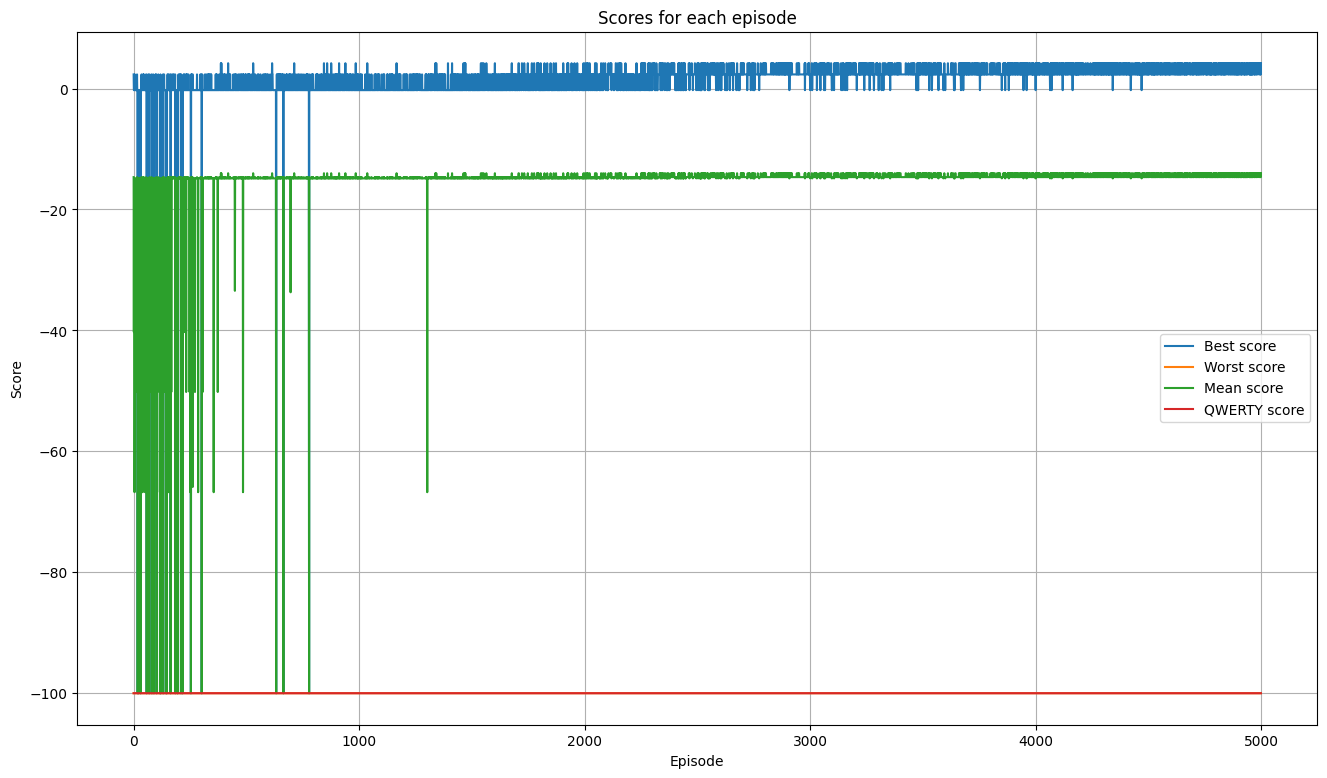

In [87]:
import matplotlib as mpl


def plot_run(scores: list[float], figsize: tuple[int, int] = (20, 9)):
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    cmap = plt.get_cmap("jet", len(scores))
    for i in range(len(scores)):
        ax1.plot(scores[i], c=cmap(i))
    norm = mpl.colors.Normalize(vmin=0, vmax=len(scores))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.arange(len(scores)), ax=ax1)
    plt.grid()
    plt.show()


def split_scores(scores):
    odd = []
    even = []
    for i in range(len(scores)):
        if (i + 1) % EVAL_INTERVAL == 0:
            odd.append(scores[i])
        else:
            even.append(scores[i])
    return odd, even


def plot_scores(scores: list[float], figsize: tuple[int, int] = (16, 9)):
    best_scores = [max(x) for x in scores]
    worst_scores = [min(x) for x in scores]
    mean_scores = [np.mean(x) for x in scores]
    qwerty_scores = [x[0] for x in scores]

    plt.subplots(1, 1, figsize=figsize)
    plt.plot(best_scores, label="Best score")
    plt.plot(worst_scores, label="Worst score")
    plt.plot(mean_scores, label="Mean score")
    plt.plot(qwerty_scores, label="QWERTY score")

    plt.legend()
    plt.grid()
    # plt.xlim([0, 500])
    # plt.ylim([best_score, 14000])
    plt.ylabel("Score")
    plt.xlabel("Episode")
    plt.title("Scores for each episode")
    plt.show()


plot_scores(scores)